Harjoitustyö, JODA 2021, Essi Partanen

Tavoitellut pisteet: 9 pistettä

    Vaihe 1: 2 pistettä (Jupyter omalla koneella)
    Vaihe 2: 1 piste (Valmis datasetti)
    Vaihe 3: 2 pistettä (Siivoaminen ja piirteiden erottaminen)
    Vaihe 4: 1 piste (Standardikuvaajat)
    Vaihe 5: 2 pistettä (Monimuuttujaregressio)
    Vaihe 6: 1 piste (Staattinen raportti)

# Airbnb Tukholma: Arvosanojen ennustaminen hinnan ja mukavuuksien lukumäärän perusteella

Tämä on Johdanto Datatieteisiin -opintojaksolle tehdyn harjoitustyön kokonaisraportti. Tähän dokumenttiin kirjataan kaikki harjoitustyön vaiheet, ja toteutetaan koko työ. Harjoitustyö jakautuu ensin datan keräämiseen, siivoamiseen, jalostamiseen ja kuvailuun, jonka jälkeen hyödynnetään koneoppimista lineaarisen regressio analyysin tuottamiseen. Harjoitustyön kehitysympäristönä toimii Jupyter omalla koneella.

Harjoituksen tarkoituksena on selvittää, voidaanko Airbnb huoneen saamaa arviointia ennustaa hinnan ja mukavuuksien avulla, ottaen huomioon vuokrattavan huonetyypin. Tarkoituksena on vastata siihen ongelmaan, että kun Airbnb:n host haluaa saada parempia arviointeja, kuinka hän voisi siihen pyrkiä. Mikäli arvioinneilla sekä hinnalla ja mukavuuksilla on korrelaatiota, voi host parantaa tarjoamansa huoneen arviointeja vaikuttamalla sen hintaan tai mukavuuksiin. Hypoteesiksi voisi asettaa, että mikäli mukavuuksia on paljon, ovat arvioinnit parempia. Hinnan osalta taas kumpikaan ääripää ei luultavasti tee hyvää arvioinneille. Kallis vuokrattava huone saattaa olla ylihintainen asiakkaiden mielestä, joka laskee sen hyötysuhdetta ja jättää huonon maun asiakkaan suuhun. Toinen ääripää on matala hinta, joka voi kieliä huonosta laadusta. Hinnan avulla huoneen arvioinnin ennustaminen voi siis osoittautua haasteelliseksi, mutta tätä halutaankin tutkia, onko siellä kenties jotain korrelaatiota kuitenkin. Hypoteesina on kuitenkin, että korkea hinta kertoo korkeasta laadusta, ja siten saa parempia arvosteluja.

Tarkastelussa on huomioitava vuokrattava huonetyyppi, sillä kokonaisen huoneiston vuokra on oletettavasti paljon kalliimpi kuin yksittäisen huoneen tai jaetun huoneen vuokraaminen. Näin ollen näiden välinen hintavertailu ei olisi mielekästä. Tässä työssä rajataankin tarkastelun kohteeksi vain koko huoneiston huonetyypit. 

## Datan kerääminen
Kuten jo mainittu, tässä harjoitustyössä hyödynnetään valmista datasettiä. Käytettävä aineisto on Tukholman Airbnb:n valmis datasetti 'listings.csv.gz', joka on kerätty Inside Airbnb sivustolle 25. helmikuuta 2021, ja ladattu sieltä 25. maaliskuuta 2021 tätä käyttöä varten omalle koneelle. Sivustolta ladattu listings -datasetti purettiin tämän harjoitustyön kanssa samaan kansioon. Tuodaan seuraavaksi datasetti dokumenttiin, ja tarkastellaan, mistä se muodostuu.

In [1]:
import pandas as pd

In [2]:
# Tallennetaan datasetti muuttujaan ja tarkastellaan, mitä sarakkeita se sisältää
listings = pd.read_csv('listings.csv')
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2796 entries, 0 to 2795
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            2796 non-null   int64  
 1   listing_url                                   2796 non-null   object 
 2   scrape_id                                     2796 non-null   int64  
 3   last_scraped                                  2796 non-null   object 
 4   name                                          2794 non-null   object 
 5   description                                   2688 non-null   object 
 6   neighborhood_overview                         1509 non-null   object 
 7   picture_url                                   2796 non-null   object 
 8   host_id                                       2796 non-null   int64  
 9   host_url                                      2796 non-null   o

Näistä jokainen sarake ei ole tähän harjoitustyöhön tarpeellisia. Aloitetaan siis pohtimalla, mitkä sarakkeet nähdään hyödyllisinä tälle harjoitustyölle, ja karsitaan datasetti sisältämään vain kyseiset sarakkeet. Otetaan listings -datasetistä mukaan vain alla luetellut sarakkeet, sillä ne edustavat haluttuja asioita, ja antavat siis relevanttia informaatiota tätä analyysia varten. Nyt 'price' edustaa huoneistolle määritettyä hintaa, 'room_type' huoneiston huonetyyppiä, 'amenities' huoneistossa mainittujen mukavuuksien listausta, 'review_scores_rating' huoneiston saamaa kokonaisarvosanaa ja 'review_scores_value' huoneiston saamaa hinta-laatusuhde arvosanaa.

In [3]:
# Tallennetaan uusi Data frame, joka sisältää vain tarvittavat sarakkeet datasetistä
df = listings[['price',
        'room_type',
        'amenities',
        'review_scores_rating',
        'review_scores_value',]]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2796 entries, 0 to 2795
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   price                 2796 non-null   object 
 1   room_type             2796 non-null   object 
 2   amenities             2796 non-null   object 
 3   review_scores_rating  2237 non-null   float64
 4   review_scores_value   2238 non-null   float64
dtypes: float64(2), object(3)
memory usage: 76.5+ KB


Työn kannalta koettiin mielenkiintoiseksi nimenomaan nämä kaksi arviointia, sillä niiden uskotaan edustavan parhaiten sitä, mitä pyritään ennustamaan. Nyt kun tavoitteena on selvittää, voidaanko hinnan ja mukavuuksien mukaan ennustaa huoneiston saamaa arviointia, puhutaan siis aika pitkälti hinta-laatusuhteesta. Kysymyksenä on, kokeeko asiakas hinnan olevan kohdallaan huoneiston tarjoamiin mukavuuksiin nähden. Oletettavasti tämä vaikuttaa asiakkaan antamaan hinta-laatusuhde arvosanaan ja myös kokonaisarvosanaan.

In [4]:
df

price        room_type  \
0       $995.00  Entire home/apt   
1       $643.00     Private room   
2     $1,387.00  Entire home/apt   
3       $669.00      Shared room   
4       $600.00     Private room   
...         ...              ...   
2791  $1,500.00  Entire home/apt   
2792    $400.00  Entire home/apt   
2793    $457.00  Entire home/apt   
2794  $1,152.00  Entire home/apt   
2795  $3,571.00  Entire home/apt   

                                              amenities  review_scores_rating  \
0     ["Smoke alarm", "Dryer", "Hair dryer", "Iron",...                 100.0   
1     ["Bed linens", "Washer", "Smoke alarm", "Dedic...                  97.0   
2     ["Dryer", "Hair dryer", "Essentials", "Hot wat...                  93.0   
3     ["Bed linens", "Wifi", "Breakfast", "Shampoo",...                  98.0   
4     ["Kitchen", "Bed linens", "Washer", "Waterfron...                  93.0   
...                                                 ...                   ...   
2791  ["Kitchen", "Private entrance", "Washer", "Iro...                   NaN   
2792  ["Kitchen", "Iron", "Heating", "Smoke alarm", ...                   NaN   
2793  ["Kitchen", "Private entrance", "TV", "Iron", ...                   NaN   
2794  ["Elevator", "Kitchen", "Private entrance", "W...                   NaN   
2795  ["Pool", "Kitchen", "Private entrance", "Washe...                   NaN   

      review_scores_value  
0                    10.0  
1                    10.0  
2                     9.0  
3                    10.0  
4                     9.0  
...                   ...  
2791                  NaN  
2792                  NaN  
2793                  NaN  
2794                  NaN  
2795                  NaN  

[2796 rows x 5 columns]

## Datan jalostaminen
Kuten huomataan yllä, on osa sarakkeiden tyypeistä numeerisia mutta osa objekteja. Se, miten näitä objekteja tullaan käsittelemään, tulee päättää. Hinnan osalta arvoista poistetaan $-merkit, ja objekti muutetaan float64-tyypiksi. Viihdykkeiden kohdalla riittää informaatio siitä, kuinka paljon viihdykkeitä on. Viihdykkeiden lista voidaan siis muuttaa numeeriseksi korvaamalla lista sen pituuden arvolla. Aiheen huonetyyppirajauksesta johtuen rajataan datasetiksi vain ne rivit, joiden huonetyyppi on 'Entire home/apt'. Kun tämä rajaus on tehty, emme tarvitse datasettiin enään tätä saraketta, jolloin tämän objektityyppi ei ole enää ongelma. Näiden muutoksien jälkeen datasetissä ei ole enää tyyppiongelmia. 

Tämän jälkeen tarkistetaan, onko datasetissä tyhjiä arvoja, ja päätetään niiden käsittelytapa. Tässä harjoitustyössä koetaan hyväksi ratkaisuksi poistaa sellaiset rivit, joissa ei ole annettu yhtään arviointia. Hinnan ja mukavuuksien sarakkeiden tyhjät arvot taas halutaan korvata mediaaneilla. Tätä ratkaisua perustellaan sillä, ettei datasetistä haluta menettää mitää arvioituja rivejä, mutta puuttuvan arvioinnin keinotekoinen lisääminen tuntuisi vääristävän ennustetta, sillä tällöin arviointeja olisi niin sanotusti tuotettu itse aineistoon. Mitä taas tulee hintaan ja mukavuuksiin, voidaan ne korvata mediaaneilla, ja pyrkiä selittämään arviointeja hyödyntämällä keskimääräistä tilannetta.

#### Datasetin rajaus koko huoneistoihin

In [5]:
# Varmistetaan ensin, mitä kaikkia arvoja huonetyyppi sarakkeesta löytyy
print(df.room_type.unique())

['Entire home/apt' 'Private room' 'Shared room' 'Hotel room']


In [6]:
# Rajataan datasetti koskemaan vain niitä rivejä, joiden huonetyypin arvo on 'Entire home/apt'
df = df.loc[df['room_type'] == 'Entire home/apt']
df

price        room_type  \
0       $995.00  Entire home/apt   
2     $1,387.00  Entire home/apt   
5       $995.00  Entire home/apt   
8     $1,652.00  Entire home/apt   
9       $360.00  Entire home/apt   
...         ...              ...   
2791  $1,500.00  Entire home/apt   
2792    $400.00  Entire home/apt   
2793    $457.00  Entire home/apt   
2794  $1,152.00  Entire home/apt   
2795  $3,571.00  Entire home/apt   

                                              amenities  review_scores_rating  \
0     ["Smoke alarm", "Dryer", "Hair dryer", "Iron",...                 100.0   
2     ["Dryer", "Hair dryer", "Essentials", "Hot wat...                  93.0   
5     ["Bed linens", "Washer", "Smoke alarm", "Dedic...                  96.0   
8     ["Elevator", "Kitchen", "TV", "Washer", "Dryer...                 100.0   
9     ["Bed linens", "Baby bath", "Washer", "Host gr...                  93.0   
...                                                 ...                   ...   
2791  ["Kitchen", "Private entrance", "Washer", "Iro...                   NaN   
2792  ["Kitchen", "Iron", "Heating", "Smoke alarm", ...                   NaN   
2793  ["Kitchen", "Private entrance", "TV", "Iron", ...                   NaN   
2794  ["Elevator", "Kitchen", "Private entrance", "W...                   NaN   
2795  ["Pool", "Kitchen", "Private entrance", "Washe...                   NaN   

      review_scores_value  
0                    10.0  
2                     9.0  
5                     9.0  
8                    10.0  
9                     9.0  
...                   ...  
2791                  NaN  
2792                  NaN  
2793                  NaN  
2794                  NaN  
2795                  NaN  

[2021 rows x 5 columns]

Huomataan, että rivien määrä laski 2796 -> 2021. Tässä on kuitenkin vielä enemmän kuin merkittävästi aineistoa. Selvästi juuri koko huoneistojen valinta oli järkevää, sillä niitä on selvästi enemmän kuin muita huonetyyppi vaihtoehtoja. Näin ollen saadaan laajempi opetusdata aikaiseksi, sekä siten myös ehkä hieman luotettavampi malli aikaseksi.

Koska nyt kaikki rivit ovat huonetyyppi-sarakkeessa arvoltaan 'Entire home/apt', voidaan kyseinen sarake poistaa datasetistä. Varmistetaan ensin vielä sarakkeen sisältö, ettei siellä ole muita arvoja. Tämän jälkeen poistetaan sarake. 

In [7]:
print(df.room_type.unique())

['Entire home/apt']


In [8]:
df = df.drop(['room_type'], axis=1)

#### Hinta numeeriseksi

In [9]:
# Poistetaan $ hinnasta ja muutetaan se floatiksi esimerkkianalyysin mukaisesti
df['price'] = df['price'].replace('[\$,)]','',  \
        regex=True).replace('[(]','-', regex=True).astype(float)
df.price.head(5)

0     995.0
2    1387.0
5     995.0
8    1652.0
9     360.0
Name: price, dtype: float64

#### Mukavuus-listaus mukavuuksien lukumääräksi
Ensimmäiseksi huomataan pienen kokeilun jäljiltä (alla), että jokainen mukavuus lista onkin tyypiltään merkkijono, eikä lista. Näin ollen ei ole mahdollista suoraan laskea listan pituutta, kun vastaus on merkkijono pituus. Merkkijono tulee siis muuntaaa listaksi, joka ymmärtää sanojen lukumäärän.

In [10]:
 for i in df.amenities:
    print(type(i))
    print(i)
    print(len(i))

<class 'str'>
["Smoke alarm", "Dryer", "Hair dryer", "Iron", "Hangers", "Washer", "TV", "Cable TV", "Kitchen", "Heating", "Wifi", "Dedicated workspace", "Long term stays allowed"]
165
<class 'str'>
["Dryer", "Hair dryer", "Essentials", "Hot water", "Hangers", "Washer", "Coffee maker", "Dishes and silverware", "Shampoo", "Elevator", "Long term stays allowed", "Kitchen", "Heating", "Extra pillows and blankets", "Bed linens"]
228
<class 'str'>
["Bed linens", "Washer", "Smoke alarm", "Dedicated workspace", "Hangers", "Bathtub", "Long term stays allowed", "Cooking basics", "Shampoo", "Iron", "Extra pillows and blankets", "Heating", "Hot water", "Room-darkening shades", "Luggage dropoff allowed", "Shower gel", "TV", "Stove", "Essentials", "Microwave", "Hair dryer", "Dishes and silverware", "Cable TV", "Garden or backyard", "Kitchen", "Coffee maker", "Dryer", "Wifi", "Refrigerator", "Oven"]
451
<class 'str'>
["Elevator", "Kitchen", "TV", "Washer", "Dryer", "Heating", "Wifi", "Cable TV", "Long

304
<class 'str'>
["Smoke alarm", "Coffee maker", "Shampoo", "Heating", "Wifi", "Garden or backyard", "Paid parking off premises", "Extra pillows and blankets", "Dryer", "Iron", "Washer", "Oven", "Refrigerator", "Cooking basics", "Kitchen", "Dishes and silverware", "Luggage dropoff allowed", "Room-darkening shades", "Elevator", "Essentials", "Hangers", "Bathtub", "Stove", "Single level home", "Hair dryer", "Hot water", "Indoor fireplace", "Carbon monoxide alarm", "Free street parking", "Ethernet connection", "Patio or balcony", "Dedicated workspace", "Long term stays allowed", "Bed linens"]
579
<class 'str'>
["Bed linens", "Host greets you", "Smoke alarm", "Dedicated workspace", "Hangers", "Lake access", "Cooking basics", "Extra pillows and blankets", "Heating", "Beachfront", "Hot water", "Elevator", "TV", "Stove", "Essentials", "Microwave", "Dishes and silverware", "Kitchen", "Waterfront", "Wifi", "Refrigerator"]
311
<class 'str'>
["Bed linens", "Washer", "Smoke alarm", "Dedicated wor

<class 'str'>
["Kitchen", "Ethernet connection", "Washer", "Iron", "Heating", "Essentials", "Wifi", "Breakfast", "Long term stays allowed"]
125
<class 'str'>
["Bed linens", "Air conditioning", "Washer", "Smoke alarm", "Dedicated workspace", "Hangers", "Bathtub", "Cooking basics", "Long term stays allowed", "Shampoo", "Iron", "Extra pillows and blankets", "Dishwasher", "Heating", "Game console", "Hot water", "Patio or balcony", "TV", "Stove", "Essentials", "Microwave", "Hair dryer", "First aid kit", "Dishes and silverware", "Fire extinguisher", "Cable TV", "Garden or backyard", "Kitchen", "Carbon monoxide alarm", "Private entrance", "Coffee maker", "Dryer", "Wifi", "Paid parking off premises", "Smart lock", "Refrigerator", "Oven"]
581
<class 'str'>
["Smoke alarm", "Coffee maker", "Shampoo", "Host greets you", "Heating", "Wifi", "Garden or backyard", "Paid parking off premises", "Dryer", "Microwave", "Washer", "Oven", "Refrigerator", "Cooking basics", "Kitchen", "Dishes and silverware", 

["Kitchen", "Washer", "Iron", "TV", "Dryer", "Heating", "Smoke alarm", "Essentials", "Wifi", "Dedicated workspace", "Hair dryer", "First aid kit", "Fire extinguisher", "Hangers", "Long term stays allowed", "Indoor fireplace", "Shampoo"]
236
<class 'str'>
["Smoke alarm", "Dryer", "Essentials", "Washer", "Shampoo", "Long term stays allowed", "Kitchen", "Heating", "Wifi", "Fire extinguisher", "Elevator"]
149
<class 'str'>
["Dryer", "Hot water", "Hangers", "Microwave", "Refrigerator", "Pack \u2019n Play/travel crib", "Room-darkening shades", "Long term stays allowed", "Fire extinguisher", "Smoke alarm", "High chair", "Kitchen", "Wifi", "Cable TV", "Essentials", "Stove", "Private entrance", "Bed linens", "TV", "Coffee maker", "Heating", "Washer", "Hair dryer", "Cooking basics", "Dishes and silverware", "Iron"]
393
<class 'str'>
["Smoke alarm", "Essentials", "TV", "Long term stays allowed", "Kitchen", "Heating", "Wifi", "Elevator"]
104
<class 'str'>
["Kitchen", "Keypad", "TV", "Washer", "Dry

<class 'str'>
["Bed linens", "Washer", "Smoke alarm", "Dedicated workspace", "BBQ grill", "Free parking on premises", "Bathtub", "Cooking basics", "Indoor fireplace", "Shampoo", "High chair", "Iron", "Extra pillows and blankets", "Dishwasher", "Heating", "Children\u2019s books and toys", "Room-darkening shades", "Children\u2019s dinnerware", "Patio or balcony", "TV", "Stove", "Essentials", "Microwave", "Hair dryer", "First aid kit", "Dishes and silverware", "Fire extinguisher", "Cable TV", "Crib", "Garden or backyard", "Kitchen", "Dryer", "Wifi", "Refrigerator", "Oven"]
562
<class 'str'>
["Smoke alarm", "Dishwasher", "Coffee maker", "High chair", "Heating", "Wifi", "Fire extinguisher", "Paid parking off premises", "Window guards", "Microwave", "Iron", "Washer", "Oven", "Refrigerator", "Cooking basics", "Kitchen", "Dishes and silverware", "Room-darkening shades", "Baby bath", "Essentials", "Hangers", "Stove", "Crib", "TV", "Cable TV", "Children\u2019s books and toys", "Pocket wifi", "Ha

["Bed linens", "Building staff", "Washer", "Smoke alarm", "Dedicated workspace", "Hangers", "Long term stays allowed", "Shampoo", "Iron", "Extra pillows and blankets", "Heating", "Hot water", "Elevator", "TV", "Essentials", "Hair dryer", "Cable TV", "Kitchen", "Dryer", "Wifi", "Paid parking off premises"]
306
<class 'str'>
["Kitchen", "TV", "Washer", "Dryer", "Wifi", "Elevator", "Long term stays allowed"]
83
<class 'str'>
["Smoke alarm", "Heating", "Wifi", "Fire extinguisher", "First aid kit", "Paid parking off premises", "Dryer", "Air conditioning", "Iron", "Washer", "Cooking basics", "Kitchen", "Dishes and silverware", "Luggage dropoff allowed", "Hangers", "Gym", "TV", "Children\u2019s books and toys", "Hair dryer", "Hot water", "Carbon monoxide alarm", "Dedicated workspace", "Long term stays allowed"]
389
<class 'str'>
["Hair dryer", "Hot water", "Hangers", "Shampoo", "Kitchen", "Wifi", "Dedicated workspace", "Building staff", "Long term stays allowed"]
136
<class 'str'>
["Bed linen

["Smoke alarm", "Iron", "Essentials", "Hangers", "Stove", "Oven", "Dishes and silverware", "Refrigerator", "Long term stays allowed", "Cooking basics", "Patio or balcony", "Kitchen", "Heating", "Wifi", "Dedicated workspace", "Elevator", "Bed linens"]
250
<class 'str'>
["Kitchen", "Washer", "TV", "Dryer", "Heating", "Hot water", "Essentials", "Wifi", "Paid parking off premises", "Dishes and silverware", "Cooking basics", "Shampoo"]
165
<class 'str'>
["Washer", "Smoke alarm", "Dedicated workspace", "Hangers", "Free parking on premises", "Bathtub", "Long term stays allowed", "Indoor fireplace", "Shampoo", "High chair", "Iron", "Heating", "Game console", "Children\u2019s books and toys", "Hot water", "Room-darkening shades", "Children\u2019s dinnerware", "TV", "Essentials", "Hair dryer", "First aid kit", "Dishes and silverware", "Fireplace guards", "Fire extinguisher", "Kitchen", "Coffee maker", "Dryer", "Wifi", "Refrigerator"]
484
<class 'str'>
["Bed linens", "Washer", "Smoke alarm", "Ded

<class 'str'>
["Bed linens", "Washer", "Host greets you", "Smoke alarm", "Dedicated workspace", "Hangers", "Long term stays allowed", "Indoor fireplace", "Ethernet connection", "Iron", "Extra pillows and blankets", "Heating", "Hot water", "Elevator", "TV", "Pocket wifi", "Essentials", "First aid kit", "Fire extinguisher", "Cable TV", "Kitchen", "Private entrance", "Dryer", "Wifi"]
369
<class 'str'>
["Kitchen", "Washer", "Iron", "TV", "Dryer", "Heating", "Smoke alarm", "Hot water", "Essentials", "Wifi", "Dedicated workspace", "Paid parking off premises", "Hair dryer", "First aid kit", "Elevator", "Long term stays allowed", "Shampoo"]
238
<class 'str'>
["Smoke alarm", "Dedicated workspace", "Hangers", "Cooking basics", "Long term stays allowed", "Shampoo", "Iron", "Dishwasher", "Hot water", "Elevator", "Luggage dropoff allowed", "Patio or balcony", "TV", "Stove", "Essentials", "Microwave", "Hair dryer", "Dishes and silverware", "Fire extinguisher", "Kitchen", "Coffee maker", "Wifi", "Pai

<class 'str'>
["Smoke alarm", "Iron", "Hot water", "Essentials", "Washer", "Indoor fireplace", "TV", "Kitchen", "Heating", "Wifi", "Fire extinguisher", "Elevator"]
149
<class 'str'>
["Bed linens", "Smoke alarm", "Dedicated workspace", "Hangers", "Cooking basics", "Long term stays allowed", "Shampoo", "Iron", "Dishwasher", "Heating", "Hot water", "Keypad", "TV", "Stove", "Essentials", "Microwave", "Hair dryer", "Dishes and silverware", "Fire extinguisher", "Cable TV", "Kitchen", "Carbon monoxide alarm", "Private entrance", "Waterfront", "Wifi", "Refrigerator", "Oven"]
391
<class 'str'>
["Bed linens", "Washer", "Host greets you", "Smoke alarm", "Dedicated workspace", "BBQ grill", "Hangers", "Cooking basics", "Long term stays allowed", "Shampoo", "High chair", "Iron", "Heating", "Beachfront", "Hot water", "Luggage dropoff allowed", "Pack \u2019n Play/travel crib", "TV", "Stove", "Essentials", "Microwave", "Dishes and silverware", "Single level home", "Fire extinguisher", "Garden or backya

<class 'str'>
["Smoke alarm", "Dryer", "Dedicated workspace", "Hair dryer", "Iron", "Essentials", "Hangers", "Washer", "TV", "Free parking on premises", "Kitchen", "Wifi", "Fire extinguisher", "Private entrance"]
198
<class 'str'>
["Coffee maker", "Shampoo", "Host greets you", "Heating", "Wifi", "Private entrance", "Air conditioning", "Iron", "Oven", "Refrigerator", "Cooking basics", "Kitchen", "Dishes and silverware", "Essentials", "Hangers", "Bathtub", "Stove", "TV", "Cable TV", "Hair dryer", "Hot water", "Free street parking", "Patio or balcony", "Dedicated workspace", "Long term stays allowed", "Bed linens"]
388
<class 'str'>
["Smoke alarm", "Dishwasher", "Coffee maker", "Shampoo", "BBQ grill", "High chair", "Host greets you", "Heating", "Wifi", "Paid parking off premises", "Extra pillows and blankets", "Dryer", "Microwave", "Iron", "Washer", "Oven", "Refrigerator", "Cooking basics", "Kitchen", "Dishes and silverware", "Room-darkening shades", "Baby bath", "Breakfast", "Essentials"

626
<class 'str'>
["Kitchen", "Carbon monoxide alarm", "Washer", "Iron", "TV", "Dryer", "Heating", "Smoke alarm", "Hot water", "Essentials", "Wifi", "Hair dryer", "Fire extinguisher", "Hangers", "Long term stays allowed", "Indoor fireplace"]
223
<class 'str'>
["Bed linens", "Air conditioning", "Washer", "Host greets you", "Smoke alarm", "Dedicated workspace", "Long term stays allowed", "Iron", "Heating", "Hot water", "Elevator", "Stove", "Microwave", "Garden or backyard", "Kitchen", "Private entrance", "Coffee maker", "Waterfront", "Wifi", "Refrigerator", "Oven"]
309
<class 'str'>
["Kitchen", "Private entrance", "Bed linens", "Lockbox", "Washer", "Iron", "TV", "Dryer", "Heating", "Smoke alarm", "Long term stays allowed", "Hot water", "Essentials", "Wifi", "Paid parking off premises", "Garden or backyard", "Fire extinguisher", "Cooking basics", "Shampoo"]
278
<class 'str'>
["Washer", "Smoke alarm", "Dedicated workspace", "Hangers", "Cooking basics", "Indoor fireplace", "Long term stays 

["Air conditioning", "Washer", "Smoke alarm", "Dedicated workspace", "Hangers", "Cooking basics", "Long term stays allowed", "Shampoo", "Iron", "Dishwasher", "Heating", "Hot water", "Elevator", "TV", "Stove", "Essentials", "Microwave", "Hair dryer", "Cable TV", "Kitchen", "Coffee maker", "Wifi", "Refrigerator", "Oven"]
320
<class 'str'>
["Kitchen", "Washer", "TV", "Dryer", "Heating", "Smoke alarm", "Essentials", "Wifi", "Hair dryer", "Hangers", "Elevator", "Long term stays allowed"]
148
<class 'str'>
["Kitchen", "Carbon monoxide alarm", "Coffee maker", "Iron", "Free street parking", "Heating", "Smoke alarm", "Essentials", "Wifi", "Refrigerator", "Oven", "Hair dryer", "Free parking on premises", "Long term stays allowed"]
224
<class 'str'>
["Coffee maker", "Heating", "Wifi", "Paid parking off premises", "Microwave", "Iron", "Washer", "Refrigerator", "Cooking basics", "Kitchen", "Dishes and silverware", "Elevator", "Essentials", "Hangers", "Stove", "Hair dryer", "Hot water", "Indoor fire

<class 'str'>
["Kitchen", "Private entrance", "Bed linens", "Lockbox", "TV", "Iron", "Long term stays allowed", "Heating", "Smoke alarm", "Hot water", "Essentials", "Wifi", "Dedicated workspace", "Hangers", "Elevator", "Cooking basics", "Shampoo"]
233
<class 'str'>
["Air conditioning", "Smoke alarm", "Dedicated workspace", "Hangers", "Free parking on premises", "Cooking basics", "Long term stays allowed", "Shampoo", "Hot tub", "Iron", "Heating", "Beachfront", "Hot water", "Keypad", "Patio or balcony", "TV", "Stove", "Essentials", "Microwave", "Hair dryer", "Dishes and silverware", "Fire extinguisher", "Garden or backyard", "Kitchen", "Private entrance", "Coffee maker", "Free street parking", "Wifi", "Refrigerator", "Oven"]
466
<class 'str'>
["Smoke alarm", "Coffee maker", "Shampoo", "Host greets you", "Heating", "Wifi", "Fire extinguisher", "Private entrance", "Paid parking off premises", "Extra pillows and blankets", "Microwave", "Iron", "Oven", "Refrigerator", "Cooking basics", "Kitc

<class 'str'>
["Smoke alarm", "Dishwasher", "Coffee maker", "BBQ grill", "Heating", "Wifi", "Fire extinguisher", "Microwave", "Iron", "Washer", "Oven", "Refrigerator", "Kitchen", "Dishes and silverware", "Essentials", "Stove", "Crib", "TV", "Sound system", "Hair dryer", "Hot water", "Indoor fireplace", "Ethernet connection", "Patio or balcony", "Dedicated workspace", "Long term stays allowed"]
382
<class 'str'>
["Bed linens", "Air conditioning", "Smoke alarm", "Dedicated workspace", "Hangers", "Cooking basics", "Long term stays allowed", "Extra pillows and blankets", "Heating", "Hot water", "Stove", "Essentials", "Microwave", "Hair dryer", "First aid kit", "Dishes and silverware", "Fire extinguisher", "Kitchen", "Carbon monoxide alarm", "Private entrance", "Coffee maker", "Waterfront", "Wifi", "Refrigerator", "Oven"]
413
<class 'str'>
["Kitchen", "Carbon monoxide alarm", "Air conditioning", "Washer", "Iron", "TV", "Dryer", "Heating", "Smoke alarm", "Essentials", "Dedicated workspace", 

239
<class 'str'>
["Washer", "Host greets you", "Dedicated workspace", "Hangers", "Cooking basics", "Long term stays allowed", "Shampoo", "Iron", "Dishwasher", "Heating", "Hot water", "Elevator", "Patio or balcony", "TV", "Stove", "Essentials", "Microwave", "Hair dryer", "Dishes and silverware", "Single level home", "Kitchen", "Coffee maker", "Dryer", "Free street parking", "Wifi", "Refrigerator", "Oven"]
390
<class 'str'>
["Dryer", "TV", "Kitchen", "Hot tub", "Wifi", "Long term stays allowed", "Shampoo", "Hot water", "Hair dryer", "Washer", "Hangers", "Heating", "Fire extinguisher", "Cable TV", "Dedicated workspace", "Elevator", "Essentials", "Iron", "Smoke alarm"]
247
<class 'str'>
["Bed linens", "Washer", "Smoke alarm", "Hangers", "Free parking on premises", "Cooking basics", "Long term stays allowed", "Shampoo", "Iron", "Extra pillows and blankets", "Dishwasher", "Heating", "Hot water", "Shower gel", "Patio or balcony", "Stove", "Essentials", "Microwave", "Hair dryer", "Dishes and 

["Kitchen", "Private entrance", "Coffee maker", "Lockbox", "Washer", "Iron", "Long term stays allowed", "Heating", "Essentials", "Wifi", "Dedicated workspace", "Microwave", "Refrigerator", "Hair dryer", "First aid kit", "Dishes and silverware", "Fire extinguisher", "Hangers", "Cooking basics", "Shampoo"]
305
<class 'str'>
["Kitchen", "Private entrance", "Lockbox", "Iron", "Long term stays allowed", "Dishwasher", "Heating", "Stove", "Essentials", "Wifi", "Dedicated workspace", "Microwave", "Refrigerator", "Hangers", "Cooking basics", "Shampoo"]
225
<class 'str'>
["Dryer", "Body soap", "Shower gel", "Hot water", "Children\u2019s dinnerware", "Hangers", "Children\u2019s books and toys", "Baby bath", "Microwave", "Dishwasher", "Refrigerator", "Changing table", "Baking sheet", "Room-darkening shades", "Shampoo", "Lake access", "Extra pillows and blankets", "Free parking on premises", "Long term stays allowed", "Smoke alarm", "Luggage dropoff allowed", "Garden or backyard", "First aid kit", 

188
<class 'str'>
["Bed linens", "Smoke alarm", "Dedicated workspace", "Hangers", "Cooking basics", "Long term stays allowed", "Shampoo", "Iron", "Extra pillows and blankets", "Dishwasher", "Heating", "Hot water", "Room-darkening shades", "Luggage dropoff allowed", "Patio or balcony", "Stove", "Pocket wifi", "Essentials", "Hair dryer", "First aid kit", "Dishes and silverware", "Fire extinguisher", "Dryer \u2013 In building", "Kitchen", "Private entrance", "Coffee maker", "Lockbox", "Washer \u2013\u00a0In building", "Wifi", "Paid parking off premises", "Refrigerator", "Oven"]
563
<class 'str'>
["Shampoo", "Wifi", "Kitchen", "Smoke alarm"]
45
<class 'str'>
["Bed linens", "Smoke alarm", "Dedicated workspace", "Hangers", "Cooking basics", "Long term stays allowed", "Shampoo", "Ethernet connection", "Iron", "Extra pillows and blankets", "Heating", "Hot water", "Shower gel", "TV", "Stove", "Essentials", "Microwave", "Hair dryer", "Dishes and silverware", "Cable TV", "Freezer", "Kitchen", "Lo

["Bed linens", "Washer", "Smoke alarm", "Hangers", "Cooking basics", "Long term stays allowed", "Shampoo", "Iron", "Extra pillows and blankets", "Dishwasher", "Heating", "Baking sheet", "Hot water", "Room-darkening shades", "Elevator", "Patio or balcony", "TV", "Stove", "Essentials", "Microwave", "Hair dryer", "First aid kit", "Dishes and silverware", "Single level home", "Fire extinguisher", "Freezer", "Kitchen", "Private entrance", "Pour-over coffee", "Coffee maker", "Dryer", "Wifi", "Refrigerator", "Oven"]
514
<class 'str'>
["Private entrance", "TV", "Heating", "Dedicated workspace", "Hangers"]
71
<class 'str'>
["Smoke alarm", "Air conditioning", "Essentials", "Hot water", "Hangers", "Carbon monoxide alarm", "Coffee maker", "Shampoo", "TV", "Private entrance", "Kitchen", "Heating", "Wifi", "Fire extinguisher", "First aid kit"]
219
<class 'str'>
["Kitchen", "Private entrance", "TV", "Washer", "Dryer", "Heating", "Smoke alarm", "Essentials", "Wifi", "Breakfast", "Microwave", "Hair dry

<class 'str'>
["Kitchen", "Private entrance", "Washer", "Dryer", "Heating", "Smoke alarm", "Essentials", "Hot water", "Wifi", "First aid kit", "Fire extinguisher", "Hangers", "Long term stays allowed"]
187
<class 'str'>
["Bed linens", "Washer", "Smoke alarm", "Dedicated workspace", "Hangers", "Bathtub", "Cooking basics", "Long term stays allowed", "Shampoo", "Iron", "Extra pillows and blankets", "Heating", "Hot water", "Room-darkening shades", "Elevator", "Luggage dropoff allowed", "Stove", "Essentials", "Microwave", "Hair dryer", "Dishes and silverware", "Fire extinguisher", "Garden or backyard", "Kitchen", "Private entrance", "Coffee maker", "Lockbox", "Dryer", "Wifi", "Paid parking off premises", "Refrigerator", "Oven"]
512
<class 'str'>
["Kitchen", "Private entrance", "Washer", "Iron", "TV", "Dryer", "Heating", "Smoke alarm", "Essentials", "Wifi", "Dedicated workspace", "Hair dryer", "Hangers", "Long term stays allowed"]
187
<class 'str'>
["Kitchen", "Iron", "Heating", "Smoke alarm

In [11]:
# Muutetaan merkkijono listaksi
def Convert(string):
    li = list(string.split(", "))
    return li
  
# Tehdään amenities-sarakkeesta kopio, jota käydään läpi sijoitettaessa uudet arvot alkuperäiseen datasettiin
amenities_copy = df['amenities'].copy()
for i in amenities_copy:
    temp = Convert(i)
    df.amenities.loc[df['amenities'] == i] = len(temp)
    print(type(temp))
    print(temp)
    print(len(temp))

<class 'list'>
['["Smoke alarm"', '"Dryer"', '"Hair dryer"', '"Iron"', '"Hangers"', '"Washer"', '"TV"', '"Cable TV"', '"Kitchen"', '"Heating"', '"Wifi"', '"Dedicated workspace"', '"Long term stays allowed"]']
13
<class 'list'>
['["Dryer"', '"Hair dryer"', '"Essentials"', '"Hot water"', '"Hangers"', '"Washer"', '"Coffee maker"', '"Dishes and silverware"', '"Shampoo"', '"Elevator"', '"Long term stays allowed"', '"Kitchen"', '"Heating"', '"Extra pillows and blankets"', '"Bed linens"]']
15
<class 'list'>
['["Bed linens"', '"Washer"', '"Smoke alarm"', '"Dedicated workspace"', '"Hangers"', '"Bathtub"', '"Long term stays allowed"', '"Cooking basics"', '"Shampoo"', '"Iron"', '"Extra pillows and blankets"', '"Heating"', '"Hot water"', '"Room-darkening shades"', '"Luggage dropoff allowed"', '"Shower gel"', '"TV"', '"Stove"', '"Essentials"', '"Microwave"', '"Hair dryer"', '"Dishes and silverware"', '"Cable TV"', '"Garden or backyard"', '"Kitchen"', '"Coffee maker"', '"Dryer"', '"Wifi"', '"Refrige

<class 'list'>
['["Kitchen"', '"Coffee maker"', '"Washer"', '"Iron"', '"TV"', '"Dryer"', '"Heating"', '"Long term stays allowed"', '"Hot water"', '"Essentials"', '"Dedicated workspace"', '"Microwave"', '"Refrigerator"', '"Paid parking off premises"', '"Hair dryer"', '"Dishes and silverware"', '"Hangers"', '"Luggage dropoff allowed"]']
18
<class 'list'>
['["Kitchen"', '"TV"', '"Washer"', '"Dryer"', '"Heating"', '"Wifi"', '"Free parking on premises"', '"Elevator"', '"Long term stays allowed"]']
9
<class 'list'>
['["Dryer"', '"Pocket wifi"', '"Children\\u2019s dinnerware"', '"Hot water"', '"Hangers"', '"Bathtub"', '"Children\\u2019s books and toys"', '"Dishwasher"', '"Refrigerator"', '"Pack \\u2019n Play/travel crib"', '"Room-darkening shades"', '"Shampoo"', '"Lake access"', '"Long term stays allowed"', '"Smoke alarm"', '"Luggage dropoff allowed"', '"Garden or backyard"', '"First aid kit"', '"High chair"', '"Kitchen"', '"Wifi"', '"Waterfront"', '"Beachfront"', '"Essentials"', '"Stove"', '

c:\users\essi\appdata\local\programs\python\python38-32\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)



['["Kitchen"', '"TV"', '"Washer"', '"Dryer"', '"Heating"', '"Smoke alarm"', '"Wifi"', '"First aid kit"', '"Free parking on premises"', '"Cable TV"', '"Long term stays allowed"]']
11
<class 'list'>
['["Elevator"', '"Kitchen"', '"Carbon monoxide alarm"', '"Washer"', '"Iron"', '"TV"', '"Dryer"', '"Heating"', '"Smoke alarm"', '"Hot water"', '"Essentials"', '"Wifi"', '"Dedicated workspace"', '"Hair dryer"', '"First aid kit"', '"Fire extinguisher"', '"Hangers"', '"Cable TV"', '"Long term stays allowed"', '"Shampoo"]']
20
<class 'list'>
['["Bed linens"', '"Washer"', '"Smoke alarm"', '"Dedicated workspace"', '"Hangers"', '"Shampoo"', '"Iron"', '"Extra pillows and blankets"', '"Heating"', '"Hot water"', '"Essentials"', '"Microwave"', '"Hair dryer"', '"First aid kit"', '"Dishes and silverware"', '"Fire extinguisher"', '"Private entrance"', '"Carbon monoxide alarm"', '"Coffee maker"', '"Lockbox"', '"Dryer"', '"Wifi"', '"Paid parking off premises"', '"Refrigerator"]']
24
<class 'list'>
['["Hair d

23
<class 'list'>
['["Smoke alarm"', '"Dishwasher"', '"Coffee maker"', '"Shampoo"', '"Heating"', '"Wifi"', '"Fire extinguisher"', '"Microwave"', '"Iron"', '"Washer"', '"Oven"', '"Refrigerator"', '"Cooking basics"', '"Kitchen"', '"Dishes and silverware"', '"Elevator"', '"Essentials"', '"Hangers"', '"Stove"', '"TV"', '"Cable TV"', '"Hair dryer"', '"Hot water"', '"Patio or balcony"', '"Long term stays allowed"', '"Bed linens"]']
26
<class 'list'>
['["Smoke alarm"', '"Dishwasher"', '"Lake access"', '"Coffee maker"', '"Shampoo"', '"BBQ grill"', '"Host greets you"', '"Heating"', '"Wifi"', '"Garden or backyard"', '"First aid kit"', '"Waterfront"', '"Private entrance"', '"Extra pillows and blankets"', '"Paid parking off premises"', '"Microwave"', '"Iron"', '"Washer"', '"Oven"', '"Refrigerator"', '"Cooking basics"', '"Kitchen"', '"Dishes and silverware"', '"Luggage dropoff allowed"', '"Room-darkening shades"', '"Essentials"', '"Hangers"', '"Bathtub"', '"Stove"', '"Beachfront"', '"TV"', '"Cable 

<class 'list'>
['["Dryer"', '"Essentials"', '"Washer"', '"Coffee maker"', '"Dishes and silverware"', '"Shampoo"', '"Long term stays allowed"', '"Kitchen"', '"Heating"', '"Wifi"', '"Dedicated workspace"', '"Elevator"]']
12
<class 'list'>
['["Kitchen"', '"TV"', '"Heating"', '"Smoke alarm"', '"Essentials"', '"Wifi"', '"Fire extinguisher"', '"Elevator"', '"Long term stays allowed"', '"Shampoo"]']
10
<class 'list'>
['["Smoke alarm"', '"Dishwasher"', '"Heating"', '"Wifi"', '"Fire extinguisher"', '"Window guards"', '"Iron"', '"Oven"', '"Refrigerator"', '"Cooking basics"', '"Kitchen"', '"Dishes and silverware"', '"Elevator"', '"Essentials"', '"Hangers"', '"Bathtub"', '"Stove"', '"Hair dryer"', '"Hot water"', '"Dedicated workspace"', '"Long term stays allowed"', '"Bed linens"]']
22
<class 'list'>
['["Air conditioning"', '"Washer"', '"Smoke alarm"', '"Dedicated workspace"', '"Hangers"', '"Free parking on premises"', '"Bathtub"', '"Cooking basics"', '"Long term stays allowed"', '"Shampoo"', '"Hig

<class 'list'>
['["Kitchen"', '"Washer"', '"Iron"', '"TV"', '"Dryer"', '"Heating"', '"Smoke alarm"', '"Essentials"', '"Wifi"', '"Dedicated workspace"', '"Hair dryer"', '"First aid kit"', '"Fire extinguisher"', '"Hangers"', '"Long term stays allowed"', '"Indoor fireplace"', '"Shampoo"]']
17
<class 'list'>
['["Smoke alarm"', '"Dryer"', '"Essentials"', '"Washer"', '"Shampoo"', '"Long term stays allowed"', '"Kitchen"', '"Heating"', '"Wifi"', '"Fire extinguisher"', '"Elevator"]']
11
<class 'list'>
['["Dryer"', '"Hot water"', '"Hangers"', '"Microwave"', '"Refrigerator"', '"Pack \\u2019n Play/travel crib"', '"Room-darkening shades"', '"Long term stays allowed"', '"Fire extinguisher"', '"Smoke alarm"', '"High chair"', '"Kitchen"', '"Wifi"', '"Cable TV"', '"Essentials"', '"Stove"', '"Private entrance"', '"Bed linens"', '"TV"', '"Coffee maker"', '"Heating"', '"Washer"', '"Hair dryer"', '"Cooking basics"', '"Dishes and silverware"', '"Iron"]']
26
<class 'list'>
['["Smoke alarm"', '"Essentials"', 

<class 'list'>
['["Elevator"', '"Kitchen"', '"Carbon monoxide alarm"', '"Washer"', '"Iron"', '"TV"', '"Dryer"', '"Heating"', '"Smoke alarm"', '"Essentials"', '"Wifi"', '"Dedicated workspace"', '"Hair dryer"', '"Hangers"', '"Cable TV"', '"Long term stays allowed"', '"Shampoo"]']
17
<class 'list'>
['["Essentials"', '"Shampoo"', '"TV"', '"Long term stays allowed"', '"Kitchen"', '"Heating"', '"Wifi"', '"Elevator"]']
8
<class 'list'>
['["Bed linens"', '"Washer"', '"Host greets you"', '"Smoke alarm"', '"Hangers"', '"Cooking basics"', '"Long term stays allowed"', '"Shampoo"', '"Dishwasher"', '"Heating"', '"Hot water"', '"Elevator"', '"Shower gel"', '"Patio or balcony"', '"TV"', '"Stove"', '"Essentials"', '"Microwave"', '"Hair dryer"', '"Dishes and silverware"', '"Fire extinguisher"', '"Cable TV"', '"Kitchen"', '"Coffee maker"', '"Dryer"', '"Wifi"', '"Refrigerator"', '"Oven"]']
28
<class 'list'>
['["Kitchen"', '"Bed linens"', '"Washer"', '"Iron"', '"TV"', '"Dryer"', '"Heating"', '"Smoke alarm"

<class 'list'>
['["Kitchen"', '"TV"', '"Smoke alarm"', '"Wifi"', '"Elevator"', '"Long term stays allowed"', '"Shampoo"]']
7
<class 'list'>
['["Kitchen"', '"TV"', '"Iron"', '"Long term stays allowed"', '"Heating"', '"Smoke alarm"', '"Hot water"', '"Essentials"', '"Wifi"', '"Dedicated workspace"', '"Free parking on premises"', '"Breakfast"', '"Hair dryer"', '"First aid kit"', '"Fire extinguisher"', '"Hangers"', '"Cooking basics"', '"Shampoo"]']
18
<class 'list'>
['["Smoke alarm"', '"Dishwasher"', '"Lake access"', '"Shampoo"', '"BBQ grill"', '"Host greets you"', '"Heating"', '"Wifi"', '"Garden or backyard"', '"Private entrance"', '"Extra pillows and blankets"', '"Oven"', '"Refrigerator"', '"Cooking basics"', '"Kitchen"', '"Dishes and silverware"', '"Essentials"', '"Hangers"', '"Stove"', '"Baking sheet"', '"TV"', '"Shower gel"', '"Hair dryer"', '"Hot water"', '"Long term stays allowed"', '"Bed linens"]']
26
<class 'list'>
['["Smoke alarm"', '"Dishwasher"', '"Nespresso machine"', '"Coffee m

<class 'list'>
['["Smoke alarm"', '"Coffee maker"', '"Shampoo"', '"Heating"', '"Wifi"', '"Fire extinguisher"', '"Garden or backyard"', '"First aid kit"', '"Paid parking off premises"', '"Extra pillows and blankets"', '"Dryer"', '"Microwave"', '"Iron"', '"Washer"', '"Oven"', '"Refrigerator"', '"Cooking basics"', '"Kitchen"', '"Dishes and silverware"', '"Elevator"', '"Essentials"', '"Hangers"', '"Stove"', '"TV"', '"Cable TV"', '"Hair dryer"', '"Hot water"', '"Dedicated workspace"', '"Long term stays allowed"', '"Bed linens"]']
30
<class 'list'>
['["Smoke alarm"', '"Dishwasher"', '"Coffee maker"', '"Shampoo"', '"Heating"', '"Wifi"', '"Paid parking off premises"', '"Game console"', '"Dryer"', '"Window guards"', '"Microwave"', '"Iron"', '"Washer"', '"Oven"', '"Refrigerator"', '"Cooking basics"', '"Kitchen"', '"Dishes and silverware"', '"Luggage dropoff allowed"', '"Baby bath"', '"Elevator"', '"Essentials"', '"Paid parking on premises"', '"Hangers"', '"Stove"', '"TV"', '"Children\\u2019s boo

<class 'list'>
['["Washer"', '"Smoke alarm"', '"Dedicated workspace"', '"Free parking on premises"', '"Hangers"', '"Long term stays allowed"', '"Indoor fireplace"', '"Shampoo"', '"Iron"', '"Heating"', '"TV"', '"Essentials"', '"Microwave"', '"Hair dryer"', '"Dishes and silverware"', '"Fire extinguisher"', '"Garden or backyard"', '"Kitchen"', '"Coffee maker"', '"Free street parking"', '"Wifi"', '"Refrigerator"]']
22
<class 'list'>
['["Elevator"', '"Kitchen"', '"Washer"', '"TV"', '"Dryer"', '"Heating"', '"Smoke alarm"', '"Essentials"', '"Wifi"', '"Cable TV"', '"Shampoo"]']
11
<class 'list'>
['["Smoke alarm"', '"Iron"', '"Essentials"', '"Hangers"', '"Washer"', '"Stove"', '"Refrigerator"', '"TV"', '"Cable TV"', '"Cooking basics"', '"Kitchen"', '"Heating"', '"Wifi"', '"Dedicated workspace"', '"Elevator"]']
15
<class 'list'>
['["Bed linens"', '"Washer"', '"Smoke alarm"', '"Dedicated workspace"', '"Hangers"', '"Cooking basics"', '"Long term stays allowed"', '"Shampoo"', '"Iron"', '"Extra pillo

<class 'list'>
['["Bed linens"', '"Washer"', '"Smoke alarm"', '"Dedicated workspace"', '"Hangers"', '"Cooking basics"', '"Long term stays allowed"', '"Iron"', '"Dishwasher"', '"Heating"', '"Hot water"', '"Elevator"', '"Patio or balcony"', '"TV"', '"Stove"', '"Essentials"', '"Microwave"', '"Hair dryer"', '"Dishes and silverware"', '"Kitchen"', '"Wifi"', '"Refrigerator"', '"Oven"]']
23
<class 'list'>
['["Kitchen"', '"Heating"', '"Wifi"', '"Essentials"', '"Dedicated workspace"', '"Hangers"', '"Long term stays allowed"', '"Shampoo"]']
8
<class 'list'>
['["Smoke alarm"', '"Dishwasher"', '"Coffee maker"', '"Shampoo"', '"Heating"', '"Wifi"', '"Fire extinguisher"', '"Paid parking off premises"', '"First aid kit"', '"Extra pillows and blankets"', '"Microwave"', '"Iron"', '"Washer"', '"Oven"', '"Refrigerator"', '"Cooking basics"', '"Kitchen"', '"Dishes and silverware"', '"Luggage dropoff allowed"', '"Room-darkening shades"', '"Building staff"', '"Essentials"', '"Paid parking on premises"', '"Han

<class 'list'>
['["Smoke alarm"', '"Kitchen"', '"Heating"', '"Wifi"', '"Long term stays allowed"]']
5
<class 'list'>
['["Kitchen"', '"Washer"', '"Iron"', '"TV"', '"Dryer"', '"Heating"', '"Smoke alarm"', '"Free street parking"', '"Hot water"', '"Essentials"', '"Wifi"', '"Dedicated workspace"', '"Paid parking off premises"', '"Fire extinguisher"', '"Hangers"', '"Long term stays allowed"]']
16
<class 'list'>
['["Smoke alarm"', '"Essentials"', '"Hot water"', '"Hangers"', '"Dishes and silverware"', '"TV"', '"Cooking basics"', '"Long term stays allowed"', '"Kitchen"', '"Heating"', '"Wifi"', '"Dedicated workspace"', '"Elevator"]']
13
<class 'list'>
['["Washer"', '"Smoke alarm"', '"Dedicated workspace"', '"Baby safety gates"', '"Free parking on premises"', '"Hangers"', '"Bathtub"', '"Long term stays allowed"', '"Indoor fireplace"', '"Shampoo"', '"Iron"', '"Heating"', '"Children\\u2019s books and toys"', '"TV"', '"Essentials"', '"Hair dryer"', '"Fireplace guards"', '"Fire extinguisher"', '"Cabl

<class 'list'>
['["Smoke alarm"', '"Lake access"', '"Essentials"', '"Hot water"', '"Shampoo"', '"TV"', '"Fire extinguisher"', '"Host greets you"', '"Kitchen"', '"Heating"', '"Wifi"', '"Dedicated workspace"', '"Paid parking off premises"]']
13
<class 'list'>
['["Kitchen"', '"Carbon monoxide alarm"', '"Washer"', '"Iron"', '"TV"', '"Host greets you"', '"Smoke alarm"', '"Hot water"', '"Essentials"', '"Wifi"', '"Dedicated workspace"', '"Hair dryer"', '"Hangers"', '"Elevator"', '"Shampoo"]']
15
<class 'list'>
['["Bed linens"', '"Washer"', '"Smoke alarm"', '"Dedicated workspace"', '"Hangers"', '"Cooking basics"', '"Indoor fireplace"', '"Long term stays allowed"', '"Ethernet connection"', '"Iron"', '"Extra pillows and blankets"', '"Dishwasher"', '"Heating"', '"Hot water"', '"Elevator"', '"TV"', '"Stove"', '"Essentials"', '"Microwave"', '"Hair dryer"', '"Dishes and silverware"', '"Single level home"', '"Fire extinguisher"', '"Cable TV"', '"Kitchen"', '"Coffee maker"', '"Lockbox"', '"Waterfront"

<class 'list'>
['["Bed linens"', '"Air conditioning"', '"Host greets you"', '"Dedicated workspace"', '"Hangers"', '"Lake access"', '"Cooking basics"', '"Shampoo"', '"Iron"', '"Extra pillows and blankets"', '"Dishwasher"', '"Heating"', '"Hot water"', '"Elevator"', '"Cleaning before checkout"', '"TV"', '"Stove"', '"Essentials"', '"Dishes and silverware"', '"Kitchen"', '"Coffee maker"', '"Waterfront"', '"Wifi"', '"Refrigerator"]']
24
<class 'list'>
['["Bed linens"', '"Washer"', '"Smoke alarm"', '"Dedicated workspace"', '"BBQ grill"', '"Outlet covers"', '"Hangers"', '"Cooking basics"', '"Long term stays allowed"', '"Shampoo"', '"Iron"', '"Extra pillows and blankets"', '"Dishwasher"', '"Heating"', '"Game console"', '"Children\\u2019s books and toys"', '"Hot water"', '"Elevator"', '"Patio or balcony"', '"TV"', '"Stove"', '"Essentials"', '"Microwave"', '"Window guards"', '"Hair dryer"', '"Dishes and silverware"', '"Cable TV"', '"Garden or backyard"', '"Kitchen"', '"Private entrance"', '"Coffe

<class 'list'>
['["Smoke alarm"', '"Shampoo"', '"Heating"', '"Wifi"', '"Dryer"', '"Iron"', '"Washer"', '"Oven"', '"Refrigerator"', '"Cooking basics"', '"Kitchen"', '"Dishes and silverware"', '"Elevator"', '"Essentials"', '"Hangers"', '"Stove"', '"TV"', '"Free parking on premises"', '"Hair dryer"', '"Hot water"', '"Carbon monoxide alarm"', '"Dedicated workspace"', '"Keypad"', '"Long term stays allowed"]']
24
<class 'list'>
['["Smoke alarm"', '"Hair dryer"', '"Iron"', '"Essentials"', '"Indoor fireplace"', '"Washer"', '"TV"', '"Kitchen"', '"Wifi"', '"Dedicated workspace"]']
10
<class 'list'>
['["Smoke alarm"', '"Dishwasher"', '"Lake access"', '"Coffee maker"', '"Body soap"', '"Shampoo"', '"Conditioner"', '"Heating"', '"Wifi"', '"Paid parking off premises"', '"Waterfront"', '"Extra pillows and blankets"', '"Air conditioning"', '"Microwave"', '"Washer"', '"Oven"', '"Refrigerator"', '"Cooking basics"', '"Kitchen"', '"Dishes and silverware"', '"Luggage dropoff allowed"', '"Elevator"', '"Essen

<class 'list'>
['["Bed linens"', '"Host greets you"', '"Smoke alarm"', '"Dedicated workspace"', '"Hangers"', '"Long term stays allowed"', '"Cooking basics"', '"Iron"', '"Heating"', '"Hot water"', '"Elevator"', '"TV"', '"Stove"', '"Essentials"', '"Microwave"', '"Hair dryer"', '"Dishes and silverware"', '"Kitchen"', '"Coffee maker"', '"Wifi"', '"Refrigerator"', '"Oven"]']
22
<class 'list'>
['["Bed linens"', '"Washer"', '"Smoke alarm"', '"Dedicated workspace"', '"Hangers"', '"Free parking on premises"', '"Cooking basics"', '"Long term stays allowed"', '"Shampoo"', '"Iron"', '"Dishwasher"', '"Heating"', '"Hot water"', '"Room-darkening shades"', '"Luggage dropoff allowed"', '"TV"', '"Stove"', '"Essentials"', '"Microwave"', '"Hair dryer"', '"First aid kit"', '"Dishes and silverware"', '"Single level home"', '"Fire extinguisher"', '"Cable TV"', '"Kitchen"', '"Carbon monoxide alarm"', '"Private entrance"', '"Coffee maker"', '"Dryer"', '"Wifi"', '"Smart lock"', '"Refrigerator"', '"Oven"]']
34
<

<class 'list'>
['["Kitchen"', '"Washer"', '"Iron"', '"TV"', '"Heating"', '"Smoke alarm"', '"Essentials"', '"Wifi"', '"Dedicated workspace"', '"Hair dryer"', '"Hangers"', '"Elevator"', '"Long term stays allowed"', '"Shampoo"]']
14
<class 'list'>
['["Elevator"', '"Kitchen"', '"Private entrance"', '"TV"', '"Iron"', '"Heating"', '"Smoke alarm"', '"Essentials"', '"Wifi"', '"Dedicated workspace"', '"Hair dryer"', '"First aid kit"', '"Fire extinguisher"', '"Hangers"', '"Cable TV"', '"Long term stays allowed"', '"Shampoo"]']
17
<class 'list'>
['["Bed linens"', '"Smoke alarm"', '"Dedicated workspace"', '"BBQ grill"', '"Free parking on premises"', '"Bathtub"', '"Cooking basics"', '"Iron"', '"Extra pillows and blankets"', '"Heating"', '"Hot water"', '"Cleaning before checkout"', '"Patio or balcony"', '"TV"', '"Stove"', '"Essentials"', '"Microwave"', '"Hair dryer"', '"Dishes and silverware"', '"Single level home"', '"Portable fans"', '"Cable TV"', '"Garden or backyard"', '"Kitchen"', '"Carbon mono

<class 'list'>
['["Dryer"', '"TV"', '"Kitchen"', '"Wifi"', '"Long term stays allowed"', '"Shampoo"', '"Washer"', '"Hair dryer"', '"Hangers"', '"Heating"', '"Indoor fireplace"', '"Dedicated workspace"', '"Elevator"', '"Essentials"', '"Iron"', '"Smoke alarm"]']
16
<class 'list'>
['["Washer"', '"Smoke alarm"', '"Dedicated workspace"', '"Hangers"', '"Free parking on premises"', '"Cooking basics"', '"Indoor fireplace"', '"Shampoo"', '"Long term stays allowed"', '"Iron"', '"Dishwasher"', '"Heating"', '"Children\\u2019s books and toys"', '"Hot water"', '"Luggage dropoff allowed"', '"TV"', '"Stove"', '"Essentials"', '"Microwave"', '"Hair dryer"', '"First aid kit"', '"Dishes and silverware"', '"Fire extinguisher"', '"Garden or backyard"', '"Pool"', '"Kitchen"', '"Coffee maker"', '"Dryer"', '"Wifi"', '"Refrigerator"', '"Oven"]']
31
<class 'list'>
['["Smoke alarm"', '"Iron"', '"Essentials"', '"Hangers"', '"Stove"', '"Oven"', '"Dishes and silverware"', '"Refrigerator"', '"Long term stays allowed"'

<class 'list'>
['["Bed linens"', '"Washer"', '"Smoke alarm"', '"BBQ grill"', '"Hangers"', '"Free parking on premises"', '"Bathtub"', '"Cooking basics"', '"Indoor fireplace"', '"Long term stays allowed"', '"Iron"', '"Extra pillows and blankets"', '"Dishwasher"', '"Heating"', '"Children\\u2019s books and toys"', '"Hot water"', '"Pack \\u2019n Play/travel crib"', '"Patio or balcony"', '"TV"', '"Stove"', '"Essentials"', '"Microwave"', '"Hair dryer"', '"Dishes and silverware"', '"Fire extinguisher"', '"Cable TV"', '"Garden or backyard"', '"Kitchen"', '"Private entrance"', '"Coffee maker"', '"Barbecue utensils"', '"Dryer"', '"Wifi"', '"Refrigerator"', '"Oven"]']
35
<class 'list'>
['["Kitchen"', '"Coffee maker"', '"TV"', '"Iron"', '"Waterfront"', '"Dishwasher"', '"Heating"', '"Smoke alarm"', '"Stove"', '"Essentials"', '"Wifi"', '"Paid parking off premises"', '"Room-darkening shades"', '"Refrigerator"', '"Hair dryer"', '"Oven"', '"Dishes and silverware"', '"Elevator"', '"Cooking basics"]']
19


['["Washer"', '"Host greets you"', '"Smoke alarm"', '"Dedicated workspace"', '"Shampoo"', '"Iron"', '"Heating"', '"Children\\u2019s books and toys"', '"Hot water"', '"Elevator"', '"Patio or balcony"', '"TV"', '"Essentials"', '"Hair dryer"', '"Dishes and silverware"', '"Garden or backyard"', '"Kitchen"', '"Coffee maker"', '"Dryer"', '"Wifi"', '"Paid parking off premises"', '"Refrigerator"]']
22
<class 'list'>
['["Kitchen"', '"Washer"', '"Iron"', '"TV"', '"Dryer"', '"Heating"', '"Smoke alarm"', '"Host greets you"', '"Hot water"', '"Essentials"', '"Dedicated workspace"', '"Paid parking on premises"', '"Hangers"', '"Elevator"', '"Long term stays allowed"', '"Shampoo"]']
16
<class 'list'>
['["Smoke alarm"', '"Lake access"', '"Coffee maker"', '"Shampoo"', '"Heating"', '"Wifi"', '"Garden or backyard"', '"Extra pillows and blankets"', '"Dryer"', '"Microwave"', '"Iron"', '"Washer"', '"Oven"', '"Refrigerator"', '"Cooking basics"', '"Kitchen"', '"Dishes and silverware"', '"Luggage dropoff allowed

<class 'list'>
['["Bed linens"', '"Smoke alarm"', '"Hangers"', '"Lake access"', '"Cooking basics"', '"Indoor fireplace"', '"Long term stays allowed"', '"Iron"', '"Extra pillows and blankets"', '"Dishwasher"', '"Heating"', '"Hot water"', '"Luggage dropoff allowed"', '"TV"', '"Stove"', '"Essentials"', '"Microwave"', '"Hair dryer"', '"First aid kit"', '"Dishes and silverware"', '"Cable TV"', '"Kitchen"', '"Coffee maker"', '"Lockbox"', '"Wifi"', '"Refrigerator"', '"Oven"]']
27
<class 'list'>
['["Bed linens"', '"Air conditioning"', '"Washer"', '"Smoke alarm"', '"Dedicated workspace"', '"BBQ grill"', '"Hangers"', '"Free parking on premises"', '"Bathtub"', '"Cooking basics"', '"Shampoo"', '"High chair"', '"Iron"', '"Dishwasher"', '"Heating"', '"Children\\u2019s books and toys"', '"Hot water"', '"Luggage dropoff allowed"', '"Children\\u2019s dinnerware"', '"Patio or balcony"', '"TV"', '"Stove"', '"Essentials"', '"Microwave"', '"Hair dryer"', '"Dishes and silverware"', '"Fire extinguisher"', '"

<class 'list'>
['["Smoke alarm"', '"Dishwasher"', '"Coffee maker"', '"Heating"', '"Wifi"', '"Fire extinguisher"', '"Dryer"', '"Microwave"', '"Iron"', '"Washer"', '"Oven"', '"Refrigerator"', '"Cooking basics"', '"Kitchen"', '"Dishes and silverware"', '"Luggage dropoff allowed"', '"Essentials"', '"Hangers"', '"Stove"', '"TV"', '"Shower gel"', '"Freezer"', '"Hair dryer"', '"Hot water"', '"Patio or balcony"', '"Free street parking"', '"Long term stays allowed"', '"Bed linens"]']
28
<class 'list'>
['["Air conditioning"', '"Washer"', '"Host greets you"', '"Smoke alarm"', '"Dedicated workspace"', '"Hangers"', '"Cooking basics"', '"Long term stays allowed"', '"Shampoo"', '"Iron"', '"Heating"', '"Hot water"', '"Elevator"', '"TV"', '"Stove"', '"Essentials"', '"Microwave"', '"First aid kit"', '"Dishes and silverware"', '"Kitchen"', '"Dryer"', '"Wifi"', '"Paid parking off premises"', '"Refrigerator"]']
24
<class 'list'>
['["Beach essentials"', '"Bed linens"', '"Air conditioning"', '"Washer"', '"Sm

<class 'list'>
['["Kitchen"', '"Bed linens"', '"Host greets you"', '"Iron"', '"Heating"', '"Hot water"', '"Essentials"', '"Wifi"', '"Dishes and silverware"', '"Hangers"', '"Long term stays allowed"', '"Shampoo"]']
12
<class 'list'>
['["Kitchen"', '"Private entrance"', '"Washer"', '"Iron"', '"TV"', '"Dryer"', '"Heating"', '"Smoke alarm"', '"Essentials"', '"Wifi"', '"Dedicated workspace"', '"Free parking on premises"', '"Breakfast"', '"Hair dryer"', '"First aid kit"', '"Fire extinguisher"', '"Hangers"', '"Shampoo"]']
18
<class 'list'>
['["Kitchen"', '"Private entrance"', '"Building staff"', '"Washer"', '"Iron"', '"TV"', '"Dryer"', '"Heating"', '"Smoke alarm"', '"Essentials"', '"Wifi"', '"Dedicated workspace"', '"Hangers"', '"Long term stays allowed"', '"Pack \\u2019n Play/travel crib"]']
15
<class 'list'>
['["Bed linens"', '"Washer"', '"Smoke alarm"', '"Gym"', '"Dedicated workspace"', '"BBQ grill"', '"Hangers"', '"Free parking on premises"', '"Cooking basics"', '"Long term stays allowed"

<class 'list'>
['["Bed linens"', '"Washer"', '"Dedicated workspace"', '"Hangers"', '"Long term stays allowed"', '"Shampoo"', '"High chair"', '"Iron"', '"Extra pillows and blankets"', '"Dishwasher"', '"Heating"', '"Children\\u2019s books and toys"', '"Hot water"', '"Luggage dropoff allowed"', '"Shower gel"', '"TV"', '"Essentials"', '"Microwave"', '"Hair dryer"', '"First aid kit"', '"Dishes and silverware"', '"Kitchen"', '"Coffee maker"', '"Dryer"', '"Wifi"', '"Refrigerator"]']
26
<class 'list'>
['["Shower gel"', '"Hot water"', '"Hangers"', '"Dishwasher"', '"Refrigerator"', '"Smart lock"', '"Long term stays allowed"', '"Fire extinguisher"', '"Smoke alarm"', '"Garden or backyard"', '"First aid kit"', '"Kitchen"', '"Wifi"', '"Ethernet connection"', '"Essentials"', '"Stove"', '"Private entrance"', '"Bed linens"', '"Coffee maker"', '"Paid parking off premises"', '"Heating"', '"Washer"', '"Cooking basics"', '"Hair dryer"', '"Dishes and silverware"', '"Carbon monoxide alarm"', '"Dedicated work

<class 'list'>
['["Bed linens"', '"Washer"', '"Host greets you"', '"Smoke alarm"', '"Dedicated workspace"', '"BBQ grill"', '"Hangers"', '"Cooking basics"', '"Long term stays allowed"', '"Shampoo"', '"Ethernet connection"', '"Iron"', '"Dishwasher"', '"Heating"', '"Sonos sound system"', '"Patio or balcony"', '"TV"', '"Stove"', '"Essentials"', '"Dishes and silverware"', '"Fire extinguisher"', '"Freezer"', '"Kitchen"', '"Coffee maker"', '"Barbecue utensils"', '"Body soap"', '"Dryer"', '"Wifi"', '"Refrigerator"', '"Oven"]']
30
<class 'list'>
['["Washer"', '"Host greets you"', '"Smoke alarm"', '"Dedicated workspace"', '"Hangers"', '"Free parking on premises"', '"Cooking basics"', '"Long term stays allowed"', '"Iron"', '"Dishwasher"', '"Heating"', '"Hot water"', '"Elevator"', '"Patio or balcony"', '"TV"', '"Essentials"', '"Microwave"', '"Hair dryer"', '"Dishes and silverware"', '"Fire extinguisher"', '"Cable TV"', '"Kitchen"', '"Coffee maker"', '"Dryer"', '"Wifi"', '"Refrigerator"', '"Oven"]'

<class 'list'>
['["Kitchen"', '"Private entrance"', '"Lockbox"', '"Washer"', '"Iron"', '"TV"', '"Dryer"', '"Heating"', '"Smoke alarm"', '"Hot water"', '"Essentials"', '"Wifi"', '"Dedicated workspace"', '"Free parking on premises"', '"Hair dryer"', '"First aid kit"', '"Fire extinguisher"', '"Hangers"', '"Indoor fireplace"', '"Shampoo"]']
20
<class 'list'>
['["Smoke alarm"', '"Dishwasher"', '"Lake access"', '"Shampoo"', '"Heating"', '"Wifi"', '"Fire extinguisher"', '"Garden or backyard"', '"Private entrance"', '"Extra pillows and blankets"', '"Microwave"', '"Iron"', '"Oven"', '"Refrigerator"', '"Cooking basics"', '"Kitchen"', '"Dishes and silverware"', '"Elevator"', '"Essentials"', '"Hangers"', '"Stove"', '"TV"', '"Shower gel"', '"Hair dryer"', '"Hot water"', '"Dedicated workspace"', '"Long term stays allowed"', '"Bed linens"]']
28
<class 'list'>
['["Bed linens"', '"Smoke alarm"', '"Gym"', '"Dedicated workspace"', '"Hangers"', '"Free parking on premises"', '"Bathtub"', '"Bread maker"', '

<class 'list'>
['["Smoke alarm"', '"Dryer"', '"Iron"', '"Hot water"', '"Essentials"', '"Washer"', '"Shampoo"', '"TV"', '"Kitchen"', '"Heating"', '"Wifi"', '"Dedicated workspace"', '"Private entrance"', '"Elevator"]']
14
<class 'list'>
['["Hot water"', '"Microwave"', '"Dishwasher"', '"Refrigerator"', '"Long term stays allowed"', '"Smoke alarm"', '"Kitchen"', '"Wifi"', '"Waterfront"', '"Essentials"', '"Stove"', '"Patio or balcony"', '"Private entrance"', '"BBQ grill"', '"Bed linens"', '"TV"', '"Coffee maker"', '"Paid parking off premises"', '"Heating"', '"Washer"', '"Hair dryer"', '"Cooking basics"', '"Dishes and silverware"', '"Dedicated workspace"', '"Oven"]']
25
<class 'list'>
['["Bed linens"', '"Washer"', '"Smoke alarm"', '"Hangers"', '"Cooking basics"', '"Long term stays allowed"', '"Shampoo"', '"Iron"', '"Dishwasher"', '"Heating"', '"Hot water"', '"Shower gel"', '"Patio or balcony"', '"TV"', '"Stove"', '"Essentials"', '"Hair dryer"', '"Dishes and silverware"', '"Garden or backyard"

<class 'list'>
['["Smoke alarm"', '"Dishwasher"', '"Lake access"', '"Beach essentials"', '"Coffee maker"', '"Body soap"', '"Shampoo"', '"Conditioner"', '"BBQ grill"', '"Heating"', '"Wifi"', '"Fire extinguisher"', '"Garden or backyard"', '"First aid kit"', '"Waterfront"', '"Private entrance"', '"Extra pillows and blankets"', '"Lockbox"', '"Dryer"', '"Window guards"', '"Microwave"', '"Iron"', '"Washer"', '"Oven"', '"Barbecue utensils"', '"Refrigerator"', '"Cooking basics"', '"Fireplace guards"', '"Kitchen"', '"Dishes and silverware"', '"Luggage dropoff allowed"', '"Room-darkening shades"', '"Cleaning before checkout"', '"Essentials"', '"Hangers"', '"Bathtub"', '"Stove"', '"Baking sheet"', '"Beachfront"', '"TV"', '"Shower gel"', '"Free parking on premises"', '"Children\\u2019s books and toys"', '"Pocket wifi"', '"Hair dryer"', '"Portable fans"', '"Hot water"', '"Indoor fireplace"', '"Carbon monoxide alarm"', '"Rice maker"', '"Free street parking"', '"Ethernet connection"', '"Pool"', '"Pat

<class 'list'>
['["Kitchen"', '"Private entrance"', '"TV"', '"Iron"', '"Long term stays allowed"', '"Heating"', '"Smoke alarm"', '"Essentials"', '"Hot water"', '"Wifi"', '"Dedicated workspace"', '"Hair dryer"', '"Dishes and silverware"', '"Cooking basics"]']
14
<class 'list'>
['["Bed linens"', '"Washer"', '"Smoke alarm"', '"Dedicated workspace"', '"BBQ grill"', '"Hangers"', '"Cooking basics"', '"Long term stays allowed"', '"Shampoo"', '"Extra pillows and blankets"', '"Dishwasher"', '"Heating"', '"Hot water"', '"Elevator"', '"Shower gel"', '"TV"', '"Stove"', '"Essentials"', '"Dishes and silverware"', '"Single level home"', '"Cable TV"', '"Garden or backyard"', '"Kitchen"', '"Coffee maker"', '"Barbecue utensils"', '"Wifi"', '"Refrigerator"', '"Oven"]']
28
<class 'list'>
['["Bed linens"', '"Washer"', '"Host greets you"', '"Smoke alarm"', '"Dedicated workspace"', '"Free parking on premises"', '"Hangers"', '"Cooking basics"', '"Indoor fireplace"', '"Long term stays allowed"', '"Iron"', '"Ex

<class 'list'>
['["Kitchen"', '"Air conditioning"', '"TV"', '"Washer"', '"Dryer"', '"Heating"', '"Smoke alarm"', '"Wifi"', '"Dedicated workspace"', '"Hair dryer"', '"Fire extinguisher"', '"Hangers"', '"Elevator"', '"Lake access"', '"Long term stays allowed"]']
15
<class 'list'>
['["Kitchen"', '"Private entrance"', '"Washer"', '"Iron"', '"TV"', '"Heating"', '"Smoke alarm"', '"Essentials"', '"Wifi"', '"Dedicated workspace"', '"Hair dryer"', '"Hangers"', '"Long term stays allowed"]']
13
<class 'list'>
['["Kitchen"', '"TV"', '"Host greets you"', '"Dishwasher"', '"Stove"', '"Smoke alarm"', '"Wifi"', '"Hot water"', '"Microwave"', '"Refrigerator"', '"Oven"', '"Dishes and silverware"', '"Cooking basics"', '"Garden or backyard"]']
14
<class 'list'>
['["Kitchen"', '"Private entrance"', '"Washer"', '"Iron"', '"Dryer"', '"Heating"', '"Smoke alarm"', '"Hot water"', '"Essentials"', '"Wifi"', '"Dedicated workspace"', '"Luggage dropoff allowed"', '"Hair dryer"', '"Hangers"', '"Cleaning before checkout

<class 'list'>
['["Beach essentials"', '"Bed linens"', '"Air conditioning"', '"Washer"', '"Host greets you"', '"Smoke alarm"', '"Dedicated workspace"', '"Hangers"', '"Free parking on premises"', '"Cooking basics"', '"Long term stays allowed"', '"Shampoo"', '"Hot tub"', '"Ethernet connection"', '"Iron"', '"Extra pillows and blankets"', '"Heating"', '"Hot water"', '"Elevator"', '"EV charger"', '"Patio or balcony"', '"TV"', '"Stove"', '"Pocket wifi"', '"Essentials"', '"Microwave"', '"First aid kit"', '"Dishes and silverware"', '"Fire extinguisher"', '"Garden or backyard"', '"Kitchen"', '"Private entrance"', '"Coffee maker"', '"Dryer"', '"Free street parking"', '"Wifi"', '"Refrigerator"', '"Oven"]']
38
<class 'list'>
['["Bed linens"', '"Washer"', '"Smoke alarm"', '"Dedicated workspace"', '"Hangers"', '"Bathtub"', '"Cooking basics"', '"Long term stays allowed"', '"Shampoo"', '"Iron"', '"Extra pillows and blankets"', '"Dishwasher"', '"Heating"', '"Children\\u2019s books and toys"', '"Hot wat

<class 'list'>
['["Essentials"', '"Hangers"', '"Cooking basics"', '"Kitchen"', '"Dishes and silverware"', '"Wifi"', '"Dedicated workspace"', '"Long term stays allowed"]']
8
<class 'list'>
['["Smoke alarm"', '"Hair dryer"', '"Essentials"', '"Hot water"', '"Hangers"', '"Washer"', '"Refrigerator"', '"Shampoo"', '"TV"', '"Cooking basics"', '"Kitchen"', '"Heating"', '"Wifi"', '"Luggage dropoff allowed"', '"Paid parking off premises"', '"Long term stays allowed"]']
16
<class 'list'>
['["Kitchen"', '"Private entrance"', '"Bed linens"', '"Lockbox"', '"Iron"', '"Long term stays allowed"', '"Extra pillows and blankets"', '"Heating"', '"Essentials"', '"Wifi"', '"Dedicated workspace"', '"Hot water"', '"Fire extinguisher"', '"Hangers"', '"Elevator"', '"Cooking basics"', '"Shampoo"]']
17
<class 'list'>
['["Smoke alarm"', '"Dishwasher"', '"Coffee maker"', '"Shampoo"', '"Host greets you"', '"Heating"', '"Wifi"', '"Fire extinguisher"', '"Private entrance"', '"Paid parking off premises"', '"Extra pillow

['["Children\\u2019s dinnerware"', '"Hot water"', '"Hangers"', '"Children\\u2019s books and toys"', '"Microwave"', '"Dishwasher"', '"Refrigerator"', '"Long term stays allowed"', '"Shampoo"', '"Elevator"', '"Smoke alarm"', '"Luggage dropoff allowed"', '"High chair"', '"Kitchen"', '"Wifi"', '"Cable TV"', '"Essentials"', '"Stove"', '"TV"', '"Coffee maker"', '"Breakfast"', '"Heating"', '"Hair dryer"', '"Cooking basics"', '"Dishes and silverware"', '"Dedicated workspace"', '"Iron"', '"Oven"]']
28
<class 'list'>
['["Private entrance"', '"Lockbox"', '"Washer"', '"TV"', '"Long term stays allowed"', '"Dryer"', '"Heating"', '"Essentials"', '"Wifi"', '"Microwave"', '"Refrigerator"', '"Dishes and silverware"', '"Hangers"', '"Cooking basics"', '"Shampoo"]']
15
<class 'list'>
['["Bed linens"', '"Air conditioning"', '"Washer"', '"Host greets you"', '"Smoke alarm"', '"Dedicated workspace"', '"BBQ grill"', '"Hangers"', '"Free parking on premises"', '"Lake access"', '"Cooking basics"', '"Long term stays

<class 'list'>
['["Elevator"', '"Kitchen"', '"Washer"', '"Iron"', '"TV"', '"Dryer"', '"Heating"', '"Smoke alarm"', '"Hot water"', '"Essentials"', '"Wifi"', '"Dedicated workspace"', '"Free parking on premises"', '"Hair dryer"', '"Hangers"', '"Cable TV"', '"Long term stays allowed"', '"Shampoo"]']
18
<class 'list'>
['["Smoke alarm"', '"Breakfast"', '"Dryer"', '"Dedicated workspace"', '"Hair dryer"', '"Iron"', '"Essentials"', '"Hangers"', '"Washer"', '"Indoor fireplace"', '"Shampoo"', '"TV"', '"Free parking on premises"', '"Kitchen"', '"Heating"', '"Wifi"', '"Fire extinguisher"', '"Private entrance"]']
18
<class 'list'>
['["Smoke alarm"', '"Dishwasher"', '"Coffee maker"', '"Shampoo"', '"Host greets you"', '"Heating"', '"Wifi"', '"Fire extinguisher"', '"Microwave"', '"Oven"', '"Refrigerator"', '"Cooking basics"', '"Dishes and silverware"', '"Elevator"', '"Essentials"', '"Stove"', '"TV"', '"Shower gel"', '"Hair dryer"', '"Hot water"', '"Bed linens"]']
21
<class 'list'>
['["Kitchen"', '"Priv

['["Kitchen"', '"Private entrance"', '"Heating"', '"Smoke alarm"', '"Hot water"', '"Essentials"', '"Wifi"', '"Hair dryer"', '"Hangers"', '"Elevator"', '"Long term stays allowed"', '"Shampoo"]']
12
<class 'list'>
['["Air conditioning"', '"TV"', '"Iron"', '"Heating"', '"Smoke alarm"', '"Essentials"', '"Wifi"', '"Hair dryer"', '"Hangers"', '"Long term stays allowed"', '"Shampoo"]']
11
<class 'list'>
['["Bed linens"', '"Dedicated workspace"', '"Hangers"', '"Cooking basics"', '"Long term stays allowed"', '"Shampoo"', '"Iron"', '"Heating"', '"Hot water"', '"Elevator"', '"TV"', '"Stove"', '"Essentials"', '"Microwave"', '"Hair dryer"', '"Dishes and silverware"', '"Fire extinguisher"', '"Kitchen"', '"Coffee maker"', '"Lockbox"', '"Wifi"', '"Paid parking off premises"', '"Refrigerator"', '"Oven"]']
24
<class 'list'>
['["Kitchen"', '"TV"', '"Washer"', '"Dryer"', '"Heating"', '"Essentials"', '"Wifi"', '"Dedicated workspace"', '"Elevator"', '"Long term stays allowed"', '"Shampoo"]']
11
<class 'list

<class 'list'>
['["Smoke alarm"', '"Dishwasher"', '"Coffee maker"', '"Shampoo"', '"High chair"', '"Heating"', '"Wifi"', '"Fire extinguisher"', '"Garden or backyard"', '"Private entrance"', '"Paid parking off premises"', '"Extra pillows and blankets"', '"Lockbox"', '"Dryer"', '"Microwave"', '"Iron"', '"Washer"', '"Oven"', '"Refrigerator"', '"Cooking basics"', '"Kitchen"', '"Dishes and silverware"', '"Elevator"', '"Cleaning before checkout"', '"Essentials"', '"Hangers"', '"Stove"', '"Hair dryer"', '"Hot water"', '"Carbon monoxide alarm"', '"Patio or balcony"', '"Dedicated workspace"', '"Long term stays allowed"', '"Bed linens"]']
34
<class 'list'>
['["Private entrance"', '"TV"', '"Iron"', '"Heating"', '"Smoke alarm"', '"Essentials"', '"Wifi"', '"Dedicated workspace"', '"Hair dryer"', '"Dishes and silverware"', '"Hangers"', '"Elevator"', '"Long term stays allowed"', '"Shampoo"]']
14
<class 'list'>
['["Kitchen"', '"TV"', '"Washer"', '"Smoke alarm"', '"Essentials"', '"Hot water"', '"Wifi"',

<class 'list'>
['["Kitchen"', '"TV"', '"Iron"', '"Hot water"', '"Essentials"', '"Wifi"', '"Refrigerator"', '"Oven"', '"Hair dryer"', '"Hangers"', '"Long term stays allowed"', '"Shampoo"]']
12
<class 'list'>
['["Smoke alarm"', '"Dryer"', '"Hair dryer"', '"Iron"', '"Essentials"', '"Indoor fireplace"', '"Washer"', '"Hot water"', '"Hangers"', '"First aid kit"', '"TV"', '"Fire extinguisher"', '"Free parking on premises"', '"Kitchen"', '"Heating"', '"Wifi"', '"Dedicated workspace"', '"Private entrance"', '"Garden or backyard"', '"Long term stays allowed"]']
20
<class 'list'>
['["Dryer"', '"TV"', '"Kitchen"', '"Wifi"', '"Coffee maker"', '"Free parking on premises"', '"Heating"', '"Washer"', '"Hair dryer"', '"Hangers"', '"Dishes and silverware"', '"Cooking basics"', '"Dedicated workspace"', '"Elevator"', '"Long term stays allowed"', '"Essentials"', '"Smoke alarm"', '"Private entrance"', '"Microwave"', '"Lockbox"]']
20
<class 'list'>
['["Smoke alarm"', '"Essentials"', '"Hot water"', '"Hangers"'

<class 'list'>
['["Smoke alarm"', '"Dryer"', '"Hair dryer"', '"Iron"', '"Essentials"', '"Hangers"', '"Washer"', '"Shampoo"', '"TV"', '"Long term stays allowed"', '"Kitchen"', '"Heating"', '"Wifi"', '"Private entrance"', '"Elevator"]']
15
<class 'list'>
['["Bed linens"', '"Washer"', '"Smoke alarm"', '"Dedicated workspace"', '"Hangers"', '"Cooking basics"', '"Long term stays allowed"', '"Shampoo"', '"Iron"', '"Extra pillows and blankets"', '"Heating"', '"Hot water"', '"Room-darkening shades"', '"Elevator"', '"Luggage dropoff allowed"', '"Patio or balcony"', '"Stove"', '"Pocket wifi"', '"Essentials"', '"Hair dryer"', '"First aid kit"', '"Dishes and silverware"', '"Fire extinguisher"', '"Kitchen"', '"Private entrance"', '"Coffee maker"', '"Lockbox"', '"Dryer"', '"Wifi"', '"Paid parking off premises"', '"Refrigerator"', '"Oven"]']
32
<class 'list'>
['["Washer"', '"Smoke alarm"', '"Gym"', '"Hangers"', '"Long term stays allowed"', '"Cooking basics"', '"Shampoo"', '"Ethernet connection"', '"Di

['["Smoke alarm"', '"Iron"', '"Hot water"', '"Hangers"', '"Essentials"', '"Indoor fireplace"', '"TV"', '"Patio or balcony"', '"Kitchen"', '"Free parking on premises"', '"Heating"', '"Wifi"', '"Dedicated workspace"]']
13
<class 'list'>
['["Kitchen"', '"Carbon monoxide alarm"', '"Air conditioning"', '"Washer"', '"Dryer"', '"Heating"', '"Smoke alarm"', '"Essentials"', '"Wifi"', '"Hair dryer"', '"First aid kit"', '"Fire extinguisher"', '"Hangers"]']
13
<class 'list'>
['["Kitchen"', '"Coffee maker"', '"Washer"', '"Iron"', '"TV"', '"Dryer"', '"Heating"', '"Smoke alarm"', '"Gym"', '"Hot water"', '"Essentials"', '"Wifi"', '"Dedicated workspace"', '"Hair dryer"', '"Hangers"', '"Elevator"', '"Long term stays allowed"', '"Shampoo"]']
18
<class 'list'>
['["Coffee maker"', '"Shampoo"', '"Heating"', '"Wifi"', '"First aid kit"', '"Iron"', '"Oven"', '"Refrigerator"', '"Cooking basics"', '"Kitchen"', '"Dishes and silverware"', '"Dedicated workspace"', '"Essentials"', '"Hangers"', '"Stove"', '"Shower ge

<class 'list'>
['["Bed linens"', '"Washer"', '"Smoke alarm"', '"Dedicated workspace"', '"Hangers"', '"Cooking basics"', '"Long term stays allowed"', '"Shampoo"', '"Iron"', '"Extra pillows and blankets"', '"Heating"', '"Hot water"', '"Room-darkening shades"', '"Elevator"', '"Cleaning before checkout"', '"Luggage dropoff allowed"', '"Patio or balcony"', '"Stove"', '"Essentials"', '"Hair dryer"', '"First aid kit"', '"Dishes and silverware"', '"Fire extinguisher"', '"Garden or backyard"', '"Kitchen"', '"Private entrance"', '"Coffee maker"', '"Lockbox"', '"Dryer"', '"Wifi"', '"Paid parking off premises"', '"Refrigerator"', '"Oven"]']
33
<class 'list'>
['["Bed linens"', '"Washer"', '"Smoke alarm"', '"Paid street parking off premises"', '"Dedicated workspace"', '"Hangers"', '"Cooking basics"', '"Long term stays allowed"', '"Shampoo"', '"Iron"', '"Extra pillows and blankets"', '"Heating"', '"Hot water"', '"Elevator"', '"Luggage dropoff allowed"', '"Stove"', '"Pocket wifi"', '"Essentials"', '"H

['["Smoke alarm"', '"Coffee maker"', '"Shampoo"', '"Heating"', '"Wifi"', '"Dryer"', '"Microwave"', '"Iron"', '"Washer"', '"Oven"', '"Refrigerator"', '"Cooking basics"', '"Kitchen"', '"Dishes and silverware"', '"Essentials"', '"Hangers"', '"Stove"', '"Shower gel"', '"Hair dryer"', '"Hot water"', '"Long term stays allowed"', '"Bed linens"]']
22
<class 'list'>
['["Bed linens"', '"Sonos Bluetooth sound system"', '"Washer"', '"Smoke alarm"', '"Central heating"', '"Piano"', '"Hangers"', '"Toaster"', '"Bathtub"', '"Cooking basics"', '"Indoor fireplace"', '"Shampoo"', '"Dining table"', '"Long term stays allowed"', '"Ethernet connection"', '"Iron"', '"Extra pillows and blankets"', '"Baking sheet"', '"Dishwasher"', '"Hot water"', '"Dedicated workspace: desk', 'office chair', 'table', 'and monitor"', '"Room-darkening shades"', '"75\\" HDTV with Apple TV', 'Netflix"', '"Cleaning products"', '"Clothing storage: walk-in closet"', '"Luggage dropoff allowed"', '"Shower gel"', '"Stove"', '"Laundromat n

<class 'list'>
['["Smoke alarm"', '"Breakfast"', '"Dryer"', '"Iron"', '"Hot water"', '"Hangers"', '"Washer"', '"Essentials"', '"Indoor fireplace"', '"Free parking on premises"', '"Kitchen"', '"Heating"', '"Wifi"', '"Dedicated workspace"', '"Private entrance"', '"Long term stays allowed"]']
16
<class 'list'>
['["Smoke alarm"', '"Dryer"', '"Dedicated workspace"', '"Hair dryer"', '"Iron"', '"Hot water"', '"Hangers"', '"Washer"', '"Essentials"', '"Carbon monoxide alarm"', '"Shampoo"', '"TV"', '"Kitchen"', '"Heating"', '"Wifi"', '"Fire extinguisher"', '"First aid kit"]']
17
<class 'list'>
['["Baby bath"', '"Washer"', '"Smoke alarm"', '"Dedicated workspace"', '"Hangers"', '"Bathtub"', '"Long term stays allowed"', '"Changing table"', '"Dishwasher"', '"Heating"', '"Children\\u2019s books and toys"', '"Hot water"', '"Patio or balcony"', '"Stove"', '"Essentials"', '"Microwave"', '"Hair dryer"', '"First aid kit"', '"Dishes and silverware"', '"Fire extinguisher"', '"Crib"', '"Kitchen"', '"Private 

<class 'list'>
['["Kitchen"', '"Air conditioning"', '"Washer"', '"Iron"', '"TV"', '"Dryer"', '"Heating"', '"Hot water"', '"Essentials"', '"Wifi"', '"Dedicated workspace"', '"Hair dryer"', '"Long term stays allowed"', '"Shampoo"]']
14
<class 'list'>
['["Bed linens"', '"Paid parking garage on premises \\u2013 1 space"', '"Smoke alarm"', '"Dedicated workspace"', '"BBQ grill"', '"Hangers"', '"Cooking basics"', '"Long term stays allowed"', '"Shampoo"', '"Iron"', '"Extra pillows and blankets"', '"Heating"', '"Hot water"', '"Patio or balcony"', '"TV"', '"Stove"', '"Pocket wifi"', '"Essentials"', '"Microwave"', '"Hair dryer"', '"First aid kit"', '"Dishes and silverware"', '"Fire extinguisher"', '"Dryer \\u2013 In building"', '"Portable fans"', '"Freezer"', '"Crib"', '"Garden or backyard"', '"Kitchen"', '"Washer \\u2013\\u00a0In unit"', '"Private entrance"', '"Coffee maker"', '"Lockbox"', '"Wifi"', '"Refrigerator"', '"Oven"]']
36
<class 'list'>
['["Kitchen"', '"Private entrance"', '"Lockbox"', 

<class 'list'>
['["Kitchen"', '"Carbon monoxide alarm"', '"Private entrance"', '"Washer"', '"Iron"', '"TV"', '"Dryer"', '"Heating"', '"Smoke alarm"', '"Essentials"', '"Wifi"', '"Dedicated workspace"', '"Free parking on premises"', '"Hair dryer"', '"First aid kit"', '"Fire extinguisher"', '"Long term stays allowed"', '"Shampoo"]']
18
<class 'list'>
['["Smoke alarm"', '"Gym"', '"Cooking basics"', '"Long term stays allowed"', '"Iron"', '"Baking sheet"', '"Heating"', '"Dishwasher"', '"Room-darkening shades"', '"TV"', '"Stove"', '"Essentials"', '"Microwave"', '"Dishes and silverware"', '"Fire extinguisher"', '"Garden or backyard"', '"Kitchen"', '"Private entrance"', '"Coffee maker"', '"Wifi"', '"Refrigerator"', '"Oven"]']
22
<class 'list'>
['["Smoke alarm"', '"Breakfast"', '"Dryer"', '"Essentials"', '"Hangers"', '"Washer"', '"Shampoo"', '"TV"', '"Kitchen"', '"Heating"', '"Wifi"', '"Dedicated workspace"', '"Private entrance"', '"Long term stays allowed"]']
14
<class 'list'>
['["Smoke alarm"'

['["Kitchen"', '"Private entrance"', '"Air conditioning"', '"Washer"', '"Dryer"', '"Heating"', '"Smoke alarm"', '"Essentials"', '"Wifi"', '"Dedicated workspace"', '"Long term stays allowed"]']
11
<class 'list'>
['["Kitchen"', '"Private entrance"', '"Washer"', '"Dryer"', '"Heating"', '"Essentials"', '"Wifi"', '"Dedicated workspace"', '"Free parking on premises"', '"Fire extinguisher"', '"Hangers"', '"Long term stays allowed"]']
12
<class 'list'>
['["Smoke alarm"', '"Dedicated workspace"', '"Hair dryer"', '"Iron"', '"Hot water"', '"Hangers"', '"Washer"', '"Essentials"', '"Shampoo"', '"TV"', '"Kitchen"', '"Heating"', '"Wifi"', '"Fire extinguisher"', '"First aid kit"', '"Long term stays allowed"]']
16
<class 'list'>
['["Kitchen"', '"Private entrance"', '"Air conditioning"', '"TV"', '"Iron"', '"Heating"', '"Smoke alarm"', '"Wifi"', '"Dedicated workspace"', '"Essentials"', '"Hangers"', '"Long term stays allowed"]']
12
<class 'list'>
['["Kitchen"', '"Private entrance"', '"Washer"', '"Iron"', 

<class 'list'>
['["Kitchen"', '"Coffee maker"', '"TV"', '"Stove"', '"Heating"', '"Dishwasher"', '"Wifi"', '"Essentials"', '"Refrigerator"', '"Oven"', '"Hangers"', '"Long term stays allowed"]']
12
<class 'list'>
['["Smoke alarm"', '"Dishwasher"', '"Coffee maker"', '"Body soap"', '"Shampoo"', '"Heating"', '"Wifi"', '"Private entrance"', '"Waterfront"', '"Extra pillows and blankets"', '"Air conditioning"', '"Microwave"', '"Iron"', '"Washer"', '"Oven"', '"Refrigerator"', '"Cooking basics"', '"Kitchen"', '"Dishes and silverware"', '"Essentials"', '"Hangers"', '"Stove"', '"TV"', '"Hair dryer"', '"Hot water"', '"Pack \\u2019n Play/travel crib"', '"Patio or balcony"', '"Dedicated workspace"', '"Keypad"', '"Long term stays allowed"', '"Bed linens"]']
31
<class 'list'>
['["Kitchen"', '"Carbon monoxide alarm"', '"Private entrance"', '"Washer"', '"TV"', '"Dryer"', '"Smoke alarm"', '"Essentials"', '"Wifi"', '"Dedicated workspace"', '"Hair dryer"', '"First aid kit"', '"Fire extinguisher"', '"Hangers

<class 'list'>
['["Kitchen"', '"Patio or balcony"', '"Washer"', '"Iron"', '"Heating"', '"Smoke alarm"', '"Essentials"', '"Wifi"', '"Hangers"', '"Long term stays allowed"', '"Shampoo"]']
11
<class 'list'>
['["Smoke alarm"', '"Dryer"', '"Iron"', '"Hangers"', '"Washer"', '"TV"', '"Kitchen"', '"Heating"', '"Wifi"', '"Long term stays allowed"]']
10
<class 'list'>
['["Bed linens"', '"Washer"', '"Host greets you"', '"Smoke alarm"', '"Gym"', '"Dedicated workspace"', '"Hangers"', '"Free parking on premises"', '"Cooking basics"', '"Long term stays allowed"', '"Shampoo"', '"Iron"', '"Extra pillows and blankets"', '"Heating"', '"Game console"', '"Hot water"', '"Room-darkening shades"', '"Elevator"', '"Luggage dropoff allowed"', '"Shower gel"', '"TV"', '"Stove"', '"Essentials"', '"Microwave"', '"Window guards"', '"Hair dryer"', '"First aid kit"', '"Dishes and silverware"', '"Fire extinguisher"', '"Crib"', '"Garden or backyard"', '"Kitchen"', '"Dryer"', '"Free street parking"', '"Wifi"', '"Refrigera

<class 'list'>
['["Dishwasher"', '"Coffee maker"', '"Heating"', '"Wifi"', '"Garden or backyard"', '"Private entrance"', '"Waterfront"', '"Dryer"', '"Microwave"', '"Iron"', '"Washer"', '"Oven"', '"Refrigerator"', '"Cooking basics"', '"Kitchen"', '"Dishes and silverware"', '"Cleaning before checkout"', '"Essentials"', '"Hangers"', '"Stove"', '"TV"', '"Hair dryer"', '"Hot water"', '"Long term stays allowed"', '"Bed linens"]']
25
<class 'list'>
['["Kitchen"', '"Private entrance"', '"Air conditioning"', '"Washer"', '"Iron"', '"TV"', '"Dryer"', '"Heating"', '"Wifi"', '"Dedicated workspace"', '"Hair dryer"', '"First aid kit"', '"Shampoo"]']
13
<class 'list'>
['["Kitchen"', '"Private entrance"', '"Keypad"', '"TV"', '"Waterfront"', '"Long term stays allowed"', '"Heating"', '"Smoke alarm"', '"Hot water"', '"Essentials"', '"Wifi"', '"Dedicated workspace"', '"Hair dryer"', '"Fire extinguisher"', '"Cooking basics"', '"Shampoo"]']
16
<class 'list'>
['["Bed linens"', '"Washer"', '"Host greets you"', 

<class 'list'>
['["Smoke alarm"', '"Dishwasher"', '"Baby safety gates"', '"Heating"', '"Wifi"', '"Fire extinguisher"', '"Garden or backyard"', '"Private entrance"', '"Extra pillows and blankets"', '"Siemens refrigerator"', '"Microwave"', '"Washer"', '"Kitchen"', '"Dishes and silverware"', '"Siemens stainless steel induction stove"', '"Siemens stainless steel oven"', '"Essentials"', '"Bathtub"', '"Baking sheet"', '"Free parking on premises"', '"Freezer"', '"Hot water"', '"Indoor fireplace"', '"Rice maker"', '"Free street parking"', '"Patio or balcony"', '"Dedicated workspace"', '"Keypad"', '"Long term stays allowed"', '"Bed linens"]']
30
<class 'list'>
['["Bed linens"', '"Building staff"', '"Air conditioning"', '"Washer"', '"Smoke alarm"', '"Dedicated workspace"', '"Hangers"', '"Free parking on premises"', '"Cooking basics"', '"Long term stays allowed"', '"Shampoo"', '"Iron"', '"Heating"', '"Hot water"', '"TV"', '"Stove"', '"Essentials"', '"Hair dryer"', '"First aid kit"', '"Fire exting

<class 'list'>
['["Smoke alarm"', '"Essentials"', '"Hangers"', '"TV"', '"Kitchen"', '"Heating"', '"Wifi"', '"Private entrance"', '"Long term stays allowed"]']
9
<class 'list'>
['["Kitchen"', '"Washer"', '"Iron"', '"TV"', '"Heating"', '"Essentials"', '"Dedicated workspace"', '"Hair dryer"', '"Hangers"]']
9
<class 'list'>
['["Kitchen"', '"Hot tub"', '"Lockbox"', '"Patio or balcony"', '"Iron"', '"Free street parking"', '"Heating"', '"Smoke alarm"', '"Hot water"', '"Essentials"', '"Wifi"', '"Dedicated workspace"', '"Breakfast"', '"Hair dryer"', '"Garden or backyard"', '"Dishes and silverware"', '"Hangers"', '"Long term stays allowed"', '"Shampoo"]']
19
<class 'list'>
['["Bed linens"', '"Washer"', '"Smoke alarm"', '"Hangers"', '"Cooking basics"', '"Long term stays allowed"', '"Shampoo"', '"Iron"', '"Extra pillows and blankets"', '"Dishwasher"', '"Heating"', '"Baking sheet"', '"Hot water"', '"Room-darkening shades"', '"Elevator"', '"Patio or balcony"', '"TV"', '"Stove"', '"Essentials"', '"Mi

<class 'list'>
['["Kitchen"', '"Private entrance"', '"Washer"', '"Iron"', '"TV"', '"Dryer"', '"Heating"', '"Smoke alarm"', '"Essentials"', '"Wifi"', '"Breakfast"', '"Hair dryer"', '"Fire extinguisher"', '"Shampoo"]']
14
<class 'list'>
['["Kitchen"', '"Private entrance"', '"Iron"', '"Dryer"', '"Heating"', '"Smoke alarm"', '"Wifi"', '"Dedicated workspace"', '"Fire extinguisher"', '"Hangers"', '"Long term stays allowed"]']
11
<class 'list'>
['["Kitchen"', '"Coffee maker"', '"TV"', '"Heating"', '"Hot water"', '"Essentials"', '"Wifi"', '"Dishes and silverware"', '"Elevator"', '"Long term stays allowed"]']
10
<class 'list'>
['["Smoke alarm"', '"Breakfast"', '"Iron"', '"Essentials"', '"Shampoo"', '"Kitchen"', '"Heating"', '"Wifi"', '"Dedicated workspace"', '"Private entrance"', '"Long term stays allowed"]']
11
<class 'list'>
['["Kitchen"', '"Private entrance"', '"Lockbox"', '"TV"', '"Long term stays allowed"', '"Stove"', '"Heating"', '"Smoke alarm"', '"Essentials"', '"Hot water"', '"Wifi"', '

<class 'list'>
['["Bed linens"', '"Washer"', '"Smoke alarm"', '"BBQ grill"', '"Clothing storage"', '"Hangers"', '"Dining table"', '"Cooking basics"', '"Lake access"', '"Shampoo"', '"Free parking on premises"', '"Long term stays allowed"', '"Hot tub"', '"Outdoor furniture"', '"Iron"', '"Extra pillows and blankets"', '"Dishwasher"', '"Heating"', '"Baking sheet"', '"Hot water"', '"Room-darkening shades"', '"Cleaning products"', '"Shower gel"', '"Patio or balcony"', '"TV"', '"Stove"', '"Essentials"', '"Microwave"', '"Outdoor dining area"', '"Hair dryer"', '"First aid kit"', '"Dishes and silverware"', '"Fire extinguisher"', '"Freezer"', '"Garden or backyard"', '"Kitchen"', '"Private entrance"', '"Wine glasses"', '"Sound system"', '"Pour-over coffee"', '"Coffee maker"', '"Barbecue utensils"', '"Dryer"', '"Wifi"', '"Refrigerator"', '"Oven"]']
46
<class 'list'>
['["Bed linens"', '"Washer"', '"Smoke alarm"', '"BBQ grill"', '"Clothing storage"', '"Hangers"', '"Dining table"', '"Cooking basics"',

<class 'list'>
['["Washer"', '"Smoke alarm"', '"Dedicated workspace"', '"BBQ grill"', '"Piano"', '"Toaster"', '"Free parking on premises"', '"Bathtub"', '"Dining table"', '"Cooking basics"', '"Lake access"', '"Outdoor furniture"', '"High chair"', '"Hot water kettle"', '"Iron"', '"Extra pillows and blankets"', '"Dishwasher"', '"Heating"', '"Children\\u2019s books and toys"', '"Hot water"', '"Room-darkening shades"', '"Cleaning products"', '"Elevator"', '"EV charger"', '"TV"', '"Stove"', '"Microwave"', '"Outdoor dining area"', '"Window guards"', '"Dishes and silverware"', '"Single level home"', '"Fire extinguisher"', '"Drying rack for clothing"', '"Portable fans"', '"Freezer"', '"Garden or backyard"', '"Kitchen"', '"Wine glasses"', '"Sound system"', '"Coffee maker"', '"Pour-over coffee"', '"Barbecue utensils"', '"Dryer"', '"Wifi"', '"Paid parking off premises"', '"Refrigerator"', '"Oven"', '"Board games"]']
48
<class 'list'>
['["Bed linens"', '"Stainless steel oven"', '"Smoke alarm"', '"

Nyt on kaikki mukavuus-listat saatu muutettua listaksi, joista voitiin laskea niiden lukumäärä. Nämä lukumäärät on sijoitettu datasettiin todistettavasti. Nyt siis datasetti näyttää seuraavalta:

In [12]:
df

price amenities  review_scores_rating  review_scores_value
0      995.0        13                 100.0                 10.0
2     1387.0        15                  93.0                  9.0
5      995.0        30                  96.0                  9.0
8     1652.0         9                 100.0                 10.0
9      360.0        35                  93.0                  9.0
...      ...       ...                   ...                  ...
2791  1500.0        14                   NaN                  NaN
2792   400.0        10                   NaN                  NaN
2793   457.0        11                   NaN                  NaN
2794  1152.0        19                   NaN                  NaN
2795  3571.0        20                   NaN                  NaN

[2021 rows x 4 columns]

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2021 entries, 0 to 2795
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   price                 2021 non-null   float64
 1   amenities             2021 non-null   object 
 2   review_scores_rating  1640 non-null   float64
 3   review_scores_value   1641 non-null   float64
dtypes: float64(3), object(1)
memory usage: 71.1+ KB


Huomataan, että amenities-sarakkeen tietotyyppi on vielä object, eikä int, joka se voisi olla. Muutetaan vielä tämä.

In [14]:
df = df.astype({"amenities": int})
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2021 entries, 0 to 2795
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   price                 2021 non-null   float64
 1   amenities             2021 non-null   int32  
 2   review_scores_rating  1640 non-null   float64
 3   review_scores_value   1641 non-null   float64
dtypes: float64(3), int32(1)
memory usage: 71.1 KB


### Tyhjien arvojen käsittely

In [15]:
# Tarkastellaan, kuinka paljon ari sarakkeissa on tyhjiä arvoja
print(df.isnull().sum())

price                     0
amenities                 0
review_scores_rating    381
review_scores_value     380
dtype: int64


In [16]:
# Tiputetaan ne rivit, joissa on tyhjiä arvoja arviointi-sarakkeissa
df = df.dropna(subset=['review_scores_rating', 'review_scores_value'])
df

price  amenities  review_scores_rating  review_scores_value
0      995.0         13                 100.0                 10.0
2     1387.0         15                  93.0                  9.0
5      995.0         30                  96.0                  9.0
8     1652.0          9                 100.0                 10.0
9      360.0         35                  93.0                  9.0
...      ...        ...                   ...                  ...
2724   631.0          9                  93.0                 10.0
2728   550.0         38                 100.0                 10.0
2729   576.0         11                 100.0                  9.0
2746   900.0         14                 100.0                 10.0
2759   750.0         13                 100.0                  8.0

[1640 rows x 4 columns]

In [17]:
print(df.isnull().sum())

price                   0
amenities               0
review_scores_rating    0
review_scores_value     0
dtype: int64


Nyt huomataan, että datasetissä ei ole enää nolla-arvoja lainkaan. Ei ole siis tarpeen käydä läpi datan jalostamisen suunnitelmaa hinta ja mukavuus attribuuttien osalta, sillä siellä ei ole tyhjiä arvoja. Näin ollen datasetti on nyt jalostettu valmiiksi tulevia harjoitusvaiheita varten.

## Datan kuvaileminen

Tässä osiossa on tarkoitus perehtyä syvemmällä tasolla datasetin sisältöön tekemällä siitä havainnollistavia visualisointeja. Ensin visualisoidaan yksittäisten sarakkeiden sisältöä, ja analysoidaan sitä. Tämän jälkeen tarkastellaan erilaisten attribuuttiparien välistä suhdetta asettamalla kahden eri sarakkeen arvoja samaan kuvaajaan. Tätä tehdään kaikille aiheen kannalta merkittäville sarake pareille.

### Histogrammien tarkastelu

In [18]:
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from pandas.plotting import scatter_matrix

#### Hinta

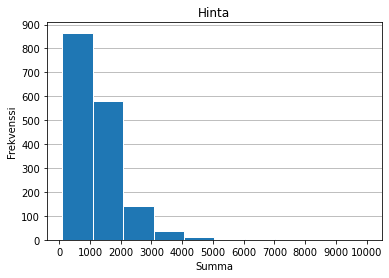

In [19]:
# Tarkastellaan hinnan vaihtelua histogrammin avulla
ax1 = df['price'].plot.hist(edgecolor = 'white', zorder = 2)

plt.title('Hinta')
plt.ylabel('Frekvenssi')
plt.xlabel('Summa')

plt.grid(axis = 'y')

# Tuunataan y- ja x-akselin näyttämään arvot järkevillä väleillä
ax1.yaxis.set_major_locator(ticker.MultipleLocator(100))
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1000))

Kuvaajasta huomataan, että hinnat ovat pääosin alle 2000. Alle 1000 saa suurimman frekvenssin aineistossa. Koska hinnat ovat niin vahvasti painottuneet kuvan vasempaan laitaan, halutaan luoda vielä tarkempi katsaus sinne. Tällä pyritään selvittämään,. miten paljon hinnat alle 2000 alla jakautuu.

(0.0, 2000.0)

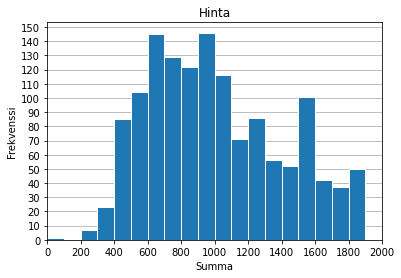

In [20]:
# Tarkempi hinnan tarkastelu
ax2 = df['price'].plot.hist(edgecolor = 'white', zorder = 2, bins=range(0, 2000, 100))

plt.title('Hinta')
plt.ylabel('Frekvenssi')
plt.xlabel('Summa')

plt.grid(axis = 'y')

# Tuunataan y- ja x-akselin näyttämään arvot järkevillä väleillä
ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax2.xaxis.set_major_locator(ticker.MultipleLocator(200))

ax2.set_xlim(0,2000)

Nyt siis huomataan, että hinnat vaihtelevat tuhannen molemmin puolin, ollen harvoin alle 400, mutta toisaalta ei kovin usein myöskään yli 1600.

#### Mukavuuksien lukumäärä

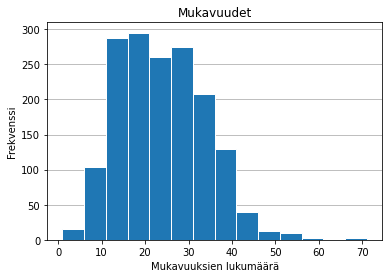

In [21]:
# Tarkastellaan mukavuuksien lukumäärän vaihtelua histogrammin avulla
ax3 = df['amenities'].plot.hist(edgecolor = 'white', zorder = 2, bins=range(min(df['amenities']), max(df['amenities']), 5))

plt.title('Mukavuudet')
plt.ylabel('Frekvenssi')
plt.xlabel('Mukavuuksien lukumäärä')

plt.grid(axis = 'y')

# Tuunataan y- ja x-akselin näyttämään arvot järkevillä väleillä
ax3.yaxis.set_major_locator(ticker.MultipleLocator(50))
ax3.xaxis.set_major_locator(ticker.MultipleLocator(10))

Kuvaajasta nähdään, että mukavuuksien lukumäärä on keskimäärin jotain 10 ja 40 välillä. Vain hyvin harvoissa on yli 45 tai alle 5 mukavuutta. Eniten on sellaisia kohteita, joissa on 15-20 mukavuutta. Koska kuvaaja on suhteellisen tasapainoinen, ei tämän attribuutin kohdalla ole tarpeellista tehdä tarkentavaa kuvaajaa. 

#### Kokonaisarvosana

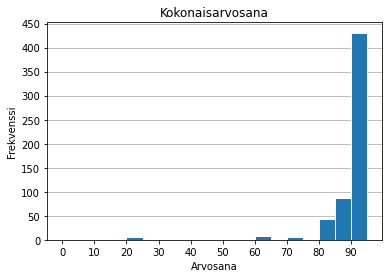

In [22]:
# Tarkastellaan kokonais arvionnin jakautumista histogrammin avulla
ax4 = df['review_scores_rating'].plot.hist(edgecolor = 'white', zorder = 2, bins=range(0, 100, 5))

plt.title('Kokonaisarvosana')
plt.ylabel('Frekvenssi')
plt.xlabel('Arvosana')

plt.grid(axis = 'y')

# Tuunataan y- ja x-akselin näyttämään arvot järkevillä väleillä
ax4.yaxis.set_major_locator(ticker.MultipleLocator(50))
ax4.xaxis.set_major_locator(ticker.MultipleLocator(10))

Kokonaisarvosanan kohdalla histogrammi on erittäin painottunut oikeaan reunaan, eli suurin osa aineiston huoneistoista saavat korkeita arvosanoja. Vain harvat saavat vähemmän kuin 80 pistettä. Otetaan siis hieman tarkempi katsaus siihen, miten arvionnit jakautuvat arvosanojen yläpäässä (80-100 pistettä).

(80.0, 100.0)

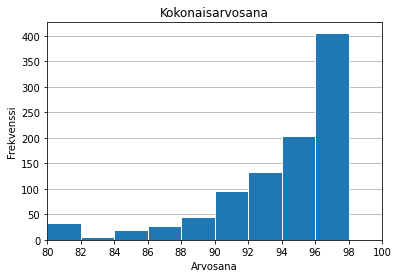

In [23]:
# Tarkempi kokonaisarvosanan tarkastelu
ax5 = df['review_scores_rating'].plot.hist(edgecolor = 'white', zorder = 2, bins=range(0, 100, 2))

plt.title('Kokonaisarvosana')
plt.ylabel('Frekvenssi')
plt.xlabel('Arvosana')

plt.grid(axis = 'y')

# Tuunataan y- ja x-akselin näyttämään arvot järkevillä väleillä
ax5.yaxis.set_major_locator(ticker.MultipleLocator(50))
ax5.xaxis.set_major_locator(ticker.MultipleLocator(2))

ax5.set_xlim(80,100)

Tästä nähdään, että huoneistot saavat kokonaisarvosanakseen eniten 96-98 pistettä. Täysiä pisteitä ei näytä juurikaan esiintyvän. Useimmiten huoneistot saavat arvosanakseen yli 90 pistettä, mikä oli jo edellisestä kuvastakin havaittavissa. Aineiston huoneistot saavat siis pääasiassa todella korkeita kokonaisarvosanoja.

#### Hinta-laatu suhteen arviointi

In [24]:
# Tarkastellaan hinta-laatusuhteen arvosanan jakautumista histogrammin avulla
ax6 = df['review_scores_value'].plot.hist(edgecolor = 'white', zorder = 2, bins=range(0, 10+1, 1))

plt.title('Hinta-laatusuhde')
plt.ylabel('Frekvenssi')
plt.xlabel('Arvosana')

plt.grid(axis = 'y')

# Tuunataan y- ja x-akselin näyttämään arvot järkevillä väleillä
ax6.yaxis.set_major_locator(ticker.MultipleLocator(100))
ax6.xaxis.set_major_locator(ticker.MultipleLocator(1))

Tässäkin, kuten kokonaisarvosanankin kohdalla, arvosanat painottuvat voimakkaasti oikealle, eli ne saavat selvästi eniten hyviä arvoja. Vain todella harvassa on alle 8 laatuarvosana, ja alle 9 saa myös alle 100 esiintymää. Tähänkin on syytä luoda vielä hieman tarkempi katsaus. 

(7.0, 10.0)

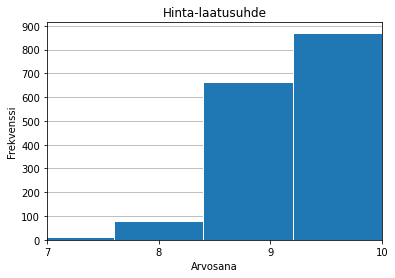

In [25]:
# Tarkempi hinta-laatusuhteen arvosanan tarkastelu
ax7 = df['review_scores_value'].plot.hist(edgecolor = 'white', zorder = 2)

plt.title('Hinta-laatusuhde')
plt.ylabel('Frekvenssi')
plt.xlabel('Arvosana')

plt.grid(axis = 'y')

# Tuunataan y- ja x-akselin näyttämään arvot järkevillä väleillä
ax7.yaxis.set_major_locator(ticker.MultipleLocator(100))
ax7.xaxis.set_major_locator(ticker.MultipleLocator(1))

ax7.set_xlim(7,10)

Arvosanoja 10 on eniten, ja arvosanoja 9 lähes yhtäpaljon. Arvosanoja 8 on enää alle 100 kappaletta, mikä todettiinkin jo aikaisemmin. 

### Attribuuttien välisten suhteiden tarkastelu

#### Hinnan ja mukavuuksien lukumäärän välinen suhde

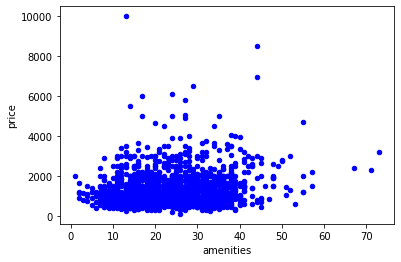

In [26]:
# Hinnan ja mukavuuksien lukumäärän välinen suhde
ax8 = df.plot.scatter(x='amenities', y='price', c='blue')

Katsotaan ensin, miten ennustettavaa muuttujaa selittävät syytekijät korreloivat keskenään datasetissä. Kuvaajasta huomataan, että eniten on sellaisia huoneistoja tarjolla, joiden hinta on alle 2000 ja niissä olevien mukavuuksien määrä vaihtelee 10 ja 40 välillä. Tämä oli tietysti havaittavissa jo histogrammeistakin, mutta tässä nähdään hyvin visualisoituna näiden kahden yhteisesiintyvyys. Huomataan, että on myös yksittäisiä tapauksia tarjolla, joissa joko hinta on hyvin korkea, mutta mukavuuksien lukumäärä keskimääräisen tienoilla. Toisaalta on myös yksittäisiä tapauksia, joissa hinta on keskimääräistä, tai hieman sitä suutempaa, mutta mukavuuksia on selvästi keskimääräistä enemmän. 

#### Hinnan ja arvosanojen välinen suhde

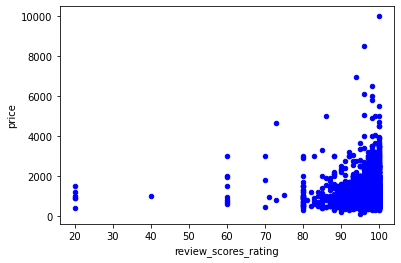

In [27]:
# Hinnan ja kokonaisarvosanan välinen suhde
ax9 = df.plot.scatter(x='review_scores_rating', y='price', c='blue')

Seuraavaksi siirrytään hieman ennakoimaan, miten syytekijät suhtautuvat ennustettavaan muuttujaan, ainakin tässä datasetissä. Tästä kuvaajasta voidaan lukea, että eniten näiden kahden attribuuttien esiintyvyyksiä on siellä, missä hinta on keskimääräistä ja arvosanat korkeat. Tästä voisi päätellä, että kun hinta on ei ole liian korkea, saadaan todennäköisemmin hyviä arvosanoja. Tähän ei kuitenkaan voida vielä varmuudella päätyä, ja tätä tarkastellaankin myöhemmin koneoppimisen kautta luotettavammin. Nyt nimittäin tämän kuvaajan perusteella on myös sellaisia tapauksia, joissa hinta on ollut keskimääräistä, mutta huoneisto onkin saanut huonon kokonaisarvosanan. 

Tärkeä huomio on toisaalta, ettei yli 4000 maksavat huoneistot ole saanut vähempää kuin 70 kokonaisarvosanakseen. Lisäksi eniten korkeahintaisia tapauksia esiintyy nimenomaan myös korkean arvosanan saaneiden joukossa (arvosanana 90-100). Tämä siis puoltaisi sitä hypoteesia, että huoneiston korkea hinta korreloisi sen laadun ja siten asiakastyytyväisyyden kanssa. Jälleen kerran tätä tullaan kuitenkin tutkimaan koneoppimismallin kautta myöhemmin lisää.

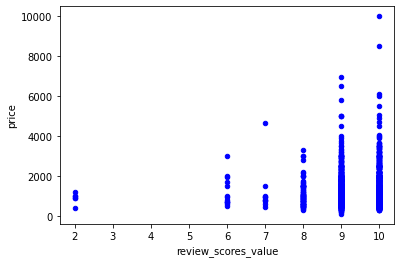

In [28]:
# Hinnan ja hinta-laatusuhteen välinen suhde
ax10 = df.plot.scatter(x='review_scores_value', y='price', c='blue')

Tästä kuvaajasta nähdään, että ne muutamat huoneistot, jotka ovat saaneet hinta-laatusuhteen arvosanakseen 2, ovat olleen alle 2000 hintaisia. Kaikista korkeimman hinnan huoneistot taas ovat saaneet arvosanan 10. Kuvaajasta voisi nähdä, että mitä parempi arvosana, sitä enemmän esiintyy korkeahintaisia huoneistoja. Toisaalta keskimääräisten hintojen huoneistot ovat saaneet myös paljon korkeita arvosanoja. Emme siis voi vetää suoria päätelmiä tästä kuvaajasta vielä suuntaan eikä toiseen. Jos varovasti kuitenkin sanotaan, voisi tässä nähdä olevan sellainen korrelaatio hinnan ja hinta-laatusuhteen arvosanan välillä, että mitä korkeampi hinta, sitä enemmän koetaan saavan myös laatua sen vastineeksi. 

#### Mukavuuksien lukumäärän ja arvosanojen välinen suhde

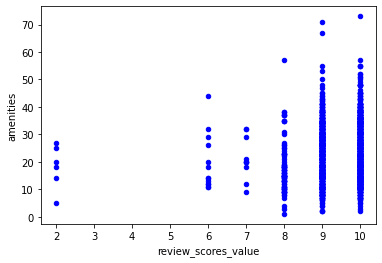

In [29]:
# Mukavuuksien lukumäärän ja hinta-laatusuhde arvosanan välinen suhde
ax11 = df.plot.scatter(x='review_scores_value', y='amenities', c='blue')

Näyttäisi siltä, että paremman hinta-laatusuhde arvosanan saaneet huoneistot sisältävät myös enemmän mukavuuksia lukumäärällisesti. Varsinkin arvosanat 9 ja 10 saaneet huoneistot sisältävät keskimäärin 10-40 mukavuutta, kun taas arvosanan 8 saaneissa huoneistossa näyttäisi olevan keskimäärin 10-30 mukavuutta, eli vähemmän kuin korkean arvosanan saaneissa huoneistoissa. 

In [30]:
# Mukavuuksien lukumäärän ja kokonaisarvosanan välinen suhde
ax12 = df.plot.scatter(x='review_scores_rating', y='amenities', c='blue')

Mitä tulee kokonaisarvosanan ja mukavuuksien lukumäärän väliseen suhteeseen näyttäisi siltä, että kaikista eniten mukavuuksia sisältävät huoneistot saavatkin korkeimpia kokonaisarvosanoja. Toisaalta näyttäisi myös siltä, että myös huonoja kokonaisarvosanoja saaneet huoneistot saattavat sisältää jopa 40 mukavuutta. Keskimäärin kuitenkin ihmiset ovat tyytyväisiä huoneistoon (kokonaisarvosana 90-100), kun siellä on 10-40 mukavuutta. Tämä oli tietysti taas pääteltävissä myös histogrammeista, mutta varmistui paremmin tästä kuvaajasta. Päätelmänä voitaisiin siis sanoa, että vaikuttaisi siltä, että alkuperäinen hypoteesi mukavuuksien lukumäärän vaikuttamisesta asiakastyytyväisyyteen olisi oikea. Mitä enemmän mukavuuksia, sitä parempi arvosana. Tämä ei kuitenkaan selvästi yksin takaa hyvää kokonaisarvosanaa.

## Koneoppiminen

Nyt olemme tutustuneet huolella siihen, mistä aineisto koostuu, ja tehneet perusteltuja oletuksia. Seuraavaksi siirrymme koneoppimisen vaiheeseen. Tässä harjoitustyössä oli tarkoituksena ennustaa huoneiston arviointia hinnan ja mukavuuksien lukumäärän perusteella. Nyt siis ennustettavat muuttujat ovat review_scores_rating ja review_scores_value, ja niitä selittävät piirteet price ja amenities. Koska selittäviä muuttujia on useampi, käytetään monimuuttuja regressiota. Lisäksi koska ennustettavia tekijöitäkin on useampi, käytetään useamman tuloksen regressiota (Multi-Output Regression). Kyseinen lähestymistapa sopii tähän, sillä kaikki arvot (selittävät ja ennustettavat) ovat numeerisia.

In [38]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
import sklearn.metrics as metrics
import numpy as np

Jaetaan data opetusdataan ja testidataan perinteisellä 80/20 suhteella.

In [32]:
X = df[['price', 'amenities']] # feature-matriisi X
y = df[['review_scores_rating', 'review_scores_value']] # targets eli ennustettavat muuttujat

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=5)

# Tarkistetaan, että jako tapahtui oikein
X_train

price  amenities
187   2300.0         23
2500  1000.0         11
13    3000.0         31
2249   946.0         33
434   1884.0         30
...      ...        ...
2221   401.0         12
1701   806.0         36
1476  2000.0         36
295   1000.0         23
1271  1550.0         33

[1312 rows x 2 columns]

In [33]:
y_train

review_scores_rating  review_scores_value
187                   96.0                  9.0
2500                 100.0                 10.0
13                    99.0                 10.0
2249                  96.0                 10.0
434                   97.0                 10.0
...                    ...                  ...
2221                  97.0                 10.0
1701                 100.0                 10.0
1476                  98.0                 10.0
295                   85.0                  9.0
1271                  96.0                 10.0

[1312 rows x 2 columns]

In [34]:
X_test

price  amenities
1036  1000.0         23
269    950.0         24
1344  1500.0         25
854    750.0         26
2603   600.0         36
...      ...        ...
2461   681.0         19
849   1800.0         38
544    590.0         15
1950   750.0         14
2428  1200.0         19

[328 rows x 2 columns]

In [35]:
y_test

review_scores_rating  review_scores_value
1036                  96.0                  8.0
269                   90.0                  9.0
1344                 100.0                 10.0
854                   98.0                 10.0
2603                 100.0                 10.0
...                    ...                  ...
2461                  92.0                 10.0
849                   99.0                 10.0
544                   93.0                  9.0
1950                 100.0                 10.0
2428                 100.0                 10.0

[328 rows x 2 columns]

Näyttää oikealta. Nyt voidaan suorittaa varsinainen mallin opettaminen.

Text(0, 0.5, 'Median Absolute Error')

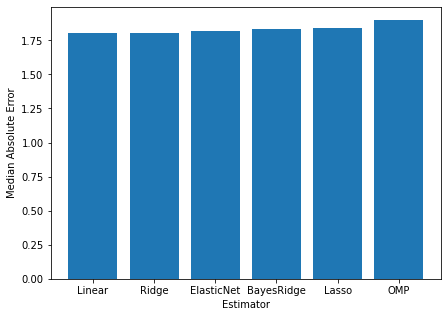

In [36]:
# Testataan eri mallien sopivuutta

rs = 1
ests = [ linear_model.LinearRegression(), linear_model.Ridge(),
        linear_model.Lasso(), linear_model.ElasticNet(),
        linear_model.BayesianRidge(), linear_model.OrthogonalMatchingPursuit() ]
ests_labels = np.array(['Linear', 'Ridge', 'Lasso', 'ElasticNet', 'BayesRidge', 'OMP'])
errvals = np.array([])

for e in ests:
    model = MultiOutputRegressor(e).fit(X_train, y_train)
    this_err = metrics.median_absolute_error(y_test, model.predict(X_test))
    #print "got error %0.2f" % this_err
    errvals = np.append(errvals, this_err)

pos = np.arange(errvals.shape[0])
srt = np.argsort(errvals)
plt.figure(figsize=(7,5))
plt.bar(pos, errvals[srt], align='center')
plt.xticks(pos, ests_labels[srt])
plt.xlabel('Estimator')
plt.ylabel('Median Absolute Error')

Näyttäisi siltä, että kaikissa tavoissa on suhteellisen vähän virhettä, mutta vähiten lineearisessa mallissa. Käytetään siis sitä. 

In [39]:
# Opetetaan malli opetusdatan avulla
model = MultiOutputRegressor(LinearRegression()).fit(X_train, y_train)
model.predict(X_train)

array([[96.25393195,  9.46715405],
       [94.78875716,  9.34875126],
       [97.13240024,  9.54229087],
       ...,
       [96.83347691,  9.55649045],
       [95.48707573,  9.43752677],
       [96.39344704,  9.52404098]])

Nyt saatu tulos on malli, joka on ennustanut opetusdatan kahden muuttujan avulla kahta arvosanaa niiden kohdalla. Tämän jälkeen on tärkeää testata mallin toimivuutta. Käytetään testaamiseen testidataa.

In [40]:
# Tarkastellaan mallin luotettavuutta
from sklearn.metrics import mean_absolute_error

y_train_predict = model.predict(X_train)
mae = (mean_absolute_error(y_train, y_train_predict)) # keskimääräinen ennustevirhe
r2 = model.score(X_train, y_train) # selityskerroin

print('Mallin sopivuus opetusdataan')
print("--------------------------------------")
print('Keskimääräinen virhe: {}'.format(mae))
print('Selityskerroin: {}'.format(r2))
print("\n")

y_test_predict = model.predict(X_test)
mae = (mean_absolute_error(y_test, y_test_predict))
r2 = model.score(X_test, y_test)

print('Mallin sopivuus testidataan')
print('--------------------------------------')
print('Keskimääräinen virhe: {}'.format(mae))
print('Selityskerroin: {}'.format(r2))

Mallin sopivuus opetusdataan
--------------------------------------
Keskimääräinen virhe: 2.2971816516090913
Selityskerroin: 0.011813177193437718


Mallin sopivuus testidataan
--------------------------------------
Keskimääräinen virhe: 2.3728059910601242
Selityskerroin: 0.007091863443634994


Tästä huomataan, että molempien mallien selityskertoimet ovat huomattavasti lähemänä nollaa kuin yhtä. Yksi olisi optimiarvo. Nolla taas tarkoittaa sellaista tilannetta, missä ennustetaan arvoa ilman selittäviä tekijöitä. Tästä päätellen malli on siis hyvin epäluotettava. Vaikuttaisi siltä, ettei hinnan ja mukavuuksien lukumäärän mukaan voida ennustaa arviointeja. Tarkastellaan vielä muutamalla muulla tavoin mallia.

In [41]:
# Tarkastellaan attribuuttien välisiä korrelaatioita
df.corr()

price  amenities  review_scores_rating  \
price                 1.000000   0.170536              0.086621   
amenities             0.170536   1.000000              0.101688   
review_scores_rating  0.086621   0.101688              1.000000   
review_scores_value   0.035962   0.106195              0.735921   

                      review_scores_value  
price                            0.035962  
amenities                        0.106195  
review_scores_rating             0.735921  
review_scores_value              1.000000

Näyttäisi siltä, että arvosanat korreloivat keskenänsä voimakkaasti, eli mikäli kokonaisarvosana on suuri, on usein hinta-laatusuhde arvosanakin suuri, ja toisinpäin. Tämä on suhteellisen looginen havainto, sillä mikäli asunto on hinta-laatusuhteeltaan hyvä, saa se luultavasti hyviä arvosanoja kokonaisuudessaankin. Hinta ja mukavuuksien lukumäärä ei puolestaan korreloi voimakkaasti arviointien kanssa. Näin ollen ei nähdä oleelliseksi lähteä enää tutkimaan, olisiko jommalla kummalla selittävällä tekijällä voitu erikseen ennustaa joko molempia tai erikseen kumpaa tahansa arviointia. 

## Toimeenpano
Tässä analyysissa tutkittiin, voidaanko huoneiston hinnan ja mukavuuksien lukumäärän avulla ennustaa huoneiston saamia arvosanoja. Tarkoituksena oli saada tietoa huoneistoja vuokraaville, voivatko he parantaa saamiansa arvosanoja lisäämällä asunnon mukavuuksien lukumääriä tai laskemalla sen hintaa. Lopputuloksena kuitenkin huomattiin, ettei arvosanaa voida ennustaa pelkästään näiden kahden selittävän tekijän avulla. 

Vaikka tämän voisi kokea olevan harmillinen lopputulos, antaa tulos kuitenkin oleellista informaatiota. Tehdyn analyysin mukaan kokonaisarviointia ja huoneiston hinta-laatusuhteen arvosanaa ei voida ennustaa huoneiston hinnan ja mukavuuksien lukumäärän perusteella. Asiakkaiden antamiin kokonaisarvosanoihin ja hinta-laatuarvosanoihin vaikuttavat varmasti monet muutkin tekijät, ja arvosanoja saatetaan antaa myös tunnepohjaisesti. Ainakaan näihin kahteen tekijään keskittyminen ei vaikuta suoraan huoneiston saamiin arvosanoihin, eikä hostin siis kannata liikaa takertua pelkästään sopivan hinnan asettamiseen ja riittävien mukavuustekijöiden lukumäärän pohtimiseen. 

Kuitenkin, kuten aineiston kuvaajista oli havaittavissa, voidaan näiden välillä havaita kuitenkin jonkinnäköistä korrelaatiota, vaikkei ne yhdessä pelkästään vaikutakaan arvosanoihin. Uskoisin, että host voi kyllä vaikuttaa hinnan ja mukavuuksien avulla arvosanoihin, kunhan ottaa huomioon myös muut tekijät. 